#Introduction + Problem Defintion.
In this notebook, an Exploratory Data Analysis will be conducted on the Ames Housing Data between 2006 to 2011. This analysis will identify trends and relationships of the houses attributes such as their prices, their area, garages as will as other attributes.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab import drive
from scipy.stats import skew
import seaborn as sns
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/DW_data/'

Mounted at /content/gdrive


In the next code block, the dataset will be read from the text file.

In [ ]:
#Read the data from the AmesDataset file as well as the column names.
with open(path+"AmesDataset.txt", "r", encoding="utf8") as f:
    reader = csv.reader(f, delimiter="\t")
    init_line = True
    col_names = []
    data = []
    for row in reader:
      if init_line:
        init_line = False
        col_names = row
      else:
        data.append(row)

#Construct an empty DataFrame and then store the appropriate data columns in them.
df = pd.DataFrame({})
data = np.array(data)
for i in range(len(col_names)):
  name = col_names[i]
  df[name] = [data[j][i] for j in range(len(data))]

df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,0526301100,020,RL,141,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,0526350040,020,RH,80,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,0526351010,020,RL,81,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,0526353030,020,RL,93,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,0527105010,060,RL,74,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


The formatting of the data from the file remains the same with a few exceptions. The first exception is every descrete variable represent by a numerical value such as the month and year the house was sold has been converted to an integer. This is so that these could be used as an equivalent to a temporal dimension for a regression model for the univariate analysis section.

The second exception is the remaining numerical values as they need to be analysed using numerical and statistical techniques such as regression techniques as well as cluster techniques.

The rest of the columns such as MS SubClass and MS Zoning will remain as they are due to the fact that changing them to a numerical value will remove the context of the values. This would mean that there would need to be a data structure or some external source to maintain which numerical value will represent which string based value from the dataset.

#Data Cleaning
In the next code block, the Data Cleaning Stage will be performed. In this step the outliers will be replaced with appropriate values. This is due to the datasets size and that the outliers are most likely  containing mistypes like an additional 0.

The columns containing missing values will be replaced with the mean of the column or the value with the highest occurrence (depending on the data type). Firstly, the columns that are integers will be handled. Then after the missing values are replaced for this columns, the remaining attributes/columns will be handled.

In [ ]:
#Find the missing values for the columns who store Continuous values.
int_titles = ['SalePrice', 'Misc Val', 'Pool Area', 'Screen Porch', '3Ssn Porch', 'Enclosed Porch', 'Open Porch SF', 'Wood Deck SF', 'Garage Area', 'Gr Liv Area',
              'Low Qual Fin SF', '2nd Flr SF', '1st Flr SF', 'Total Bsmt SF', 'Bsmt Unf SF', 'BsmtFin SF 2', 'BsmtFin SF 1', 'Lot Area', 'Lot Frontage', 'Mas Vnr Area']
for t in int_titles:
  #Find the missing ('') values in the dimensions.
  idx = df[t].where(df[t] == '')
  missing = [i for i in range(len(idx)) if idx[i] == '']
  
  #Find the average (mean) to replace the missing values with.
  mu = [float(df[t][i]) for i in range(len(df[t])) if (i in missing) == False]
  mu = sum(mu)/len(df[t])

  #Convert the column into an appropriate value.
  df[t] = [float(df[t][i]) if (i in missing) == False else mu for i in range(len(df[t]))]

#Find the missing values for the columns who store non-continuous values.
titles = [t for t in df if (t in int_titles) == False and t != 'Order']
for t in titles:
  #Find the missing ('') values in the dimensions.
  idx = df[t].where(df[t] == '')
  missing = [i for i in range(len(idx)) if idx[i] == '']

  #Find the highest occurring value in this column.
  temp, counts = df[t].unique(), []
  for x in temp:
    count = [1 for n in df[t] if n == x and x != '']
    count = sum(count)
    counts.append(count)
  
  #Find the maximum value in counts whilst storing the index. This is so the actual variable can be accessed from temp.
  max, index = 0, 0
  for i in range(len(counts)):
    if max < counts[i]:
      max = counts[i]
      index = i

  #Store the value with the highest occurences in the rows with the missing values.
  df.loc[df[t] == '', t] = temp[index]

The following code block fixes any of the values that are out of the bounds of a valid range. Such as a house being sold on a year past 2022, then the appropriate digit will be changed to match the range of the rest of the dataset.

In [ ]:
#Make sure there are valid years for a garage to of been built or a house to of been sold.
for t in ['Garage Yr Blt', 'Year Built', 'Year Remod/Add', 'Yr Sold']:
  yrs = df[t].unique()
  print(t, " => ", [y for y in yrs if int(y) > 2022])

#Do the same as the above loop but for the columns pretaining to months.
print("")
for t in ['Mo Sold']:
  mths = df[t].unique()
  print(t, " => ", [y for y in mths if int(y) > 12])

Garage Yr Blt  =>  ['2207']
Year Built  =>  []
Year Remod/Add  =>  []
Yr Sold  =>  []

Mo Sold  =>  []


Given that the out of bounds values have been identified, they can now be removed from the columns by being replaced by an appropriate value.

In [ ]:
#There is an assumption that this value is a typo of the year 2007, so it is replaced by that.
df.loc[df['Garage Yr Blt'] == '2207', 'Garage Yr Blt'] = '2007'

Replace the outliers in each column with the median of the column. This is because the median is not affected by the outliers of the column like the mean and that the dataset is small in size in relative terms (for example the MNIST and EMNIST datasets).

In [ ]:
import math
q1, q3 = df[int_titles].quantile(0.25), df[int_titles].quantile(0.75)
IQR = q3 - q1
outliers = df[int_titles].where((df[int_titles] < (q1-1.5*IQR)) | (df[int_titles] > (q3+1.5*IQR)))

keep_indices = []
for i in range(len(df['Order'])):
  #Find the indices of the rows that do not have any outliers.
  temp = []
  for t in int_titles:
    if math.isnan(outliers.iloc[i][t]):
      temp.append(t)

  #If temp == int_titles, that means that all of the columns contain NaN and therefore are not outliers.
  if temp == int_titles:
    keep_indices.append(i)

#Find the indices we are dropping.
drop_indices = [i for i in range(len(df['Order'])) if (i in keep_indices) == False]

#As we are working with numerical values, we 
#Given that we know what the indices are, we can replace them with the attributes.
for t in int_titles:
  #Find the median of the column.
  median = np.median(df[t])

  #Replace the outliers by the median value of the column.
  for i in df.iloc[drop_indices]:
    df[t] = np.where(df[t]==i, median, df[t])

temporary = df

#Univariate Analysis.
In the following 2 Code Blocks, there will a linear regression (and then a polynomial regression) analysis to identify the relationship between each column.

Each regression model is then visualized in a 2d Histogram plot to show the gradients (relationships) distributions across the columns.

Probability Distributions
-------------------------
SalePrice => (Mean, Standard Deviation, Skewness) = (180796.0600682594, 79886.692356665, 1.7426073719460107)


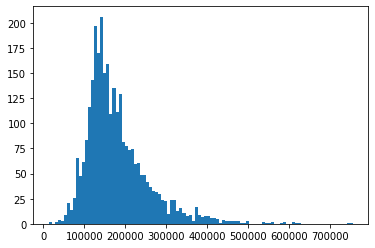

Misc Val => (Mean, Standard Deviation, Skewness) = (50.63515358361775, 566.3442882590892, 21.988523324296214)


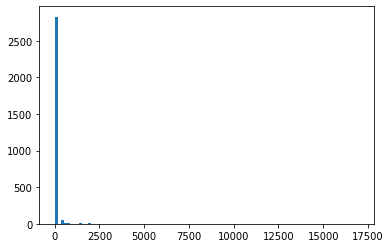

Pool Area => (Mean, Standard Deviation, Skewness) = (2.243344709897611, 35.597180615097685, 16.930469347882216)


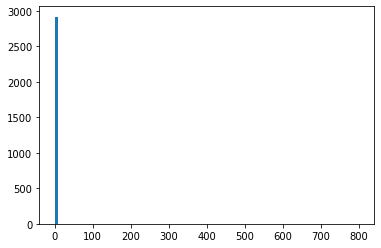

Screen Porch => (Mean, Standard Deviation, Skewness) = (16.002047781569967, 56.08737022943253, 3.955441025871492)


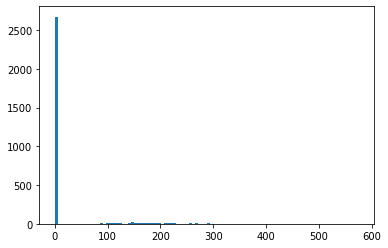

3Ssn Porch => (Mean, Standard Deviation, Skewness) = (2.592491467576792, 25.141331031869438, 11.39795591155961)


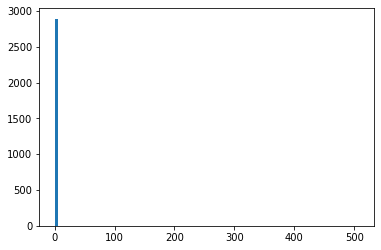

Enclosed Porch => (Mean, Standard Deviation, Skewness) = (23.01160409556314, 64.13905920864133, 4.012390205634154)


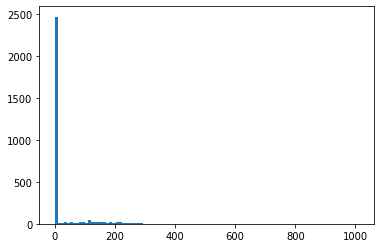

Open Porch SF => (Mean, Standard Deviation, Skewness) = (47.53344709897611, 67.48340013677367, 2.5340877554403782)


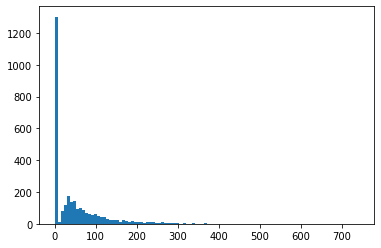

Wood Deck SF => (Mean, Standard Deviation, Skewness) = (93.75187713310581, 126.36156187890577, 1.8417346144174296)


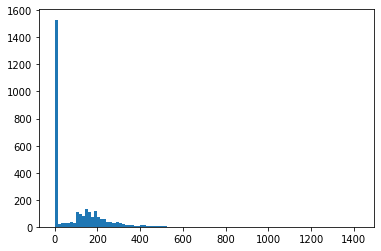

Garage Area => (Mean, Standard Deviation, Skewness) = (472.8196786217662, 215.00983553564546, 0.24191234566455727)


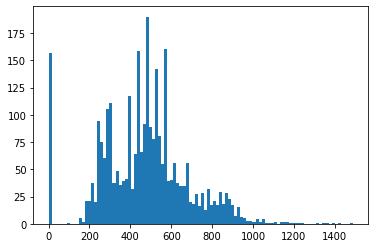

Gr Liv Area => (Mean, Standard Deviation, Skewness) = (1499.6904436860068, 505.508887472041, 1.2734573491164038)


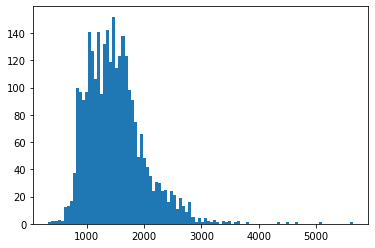

Low Qual Fin SF => (Mean, Standard Deviation, Skewness) = (4.67679180887372, 46.3105100344704, 12.111956844115396)


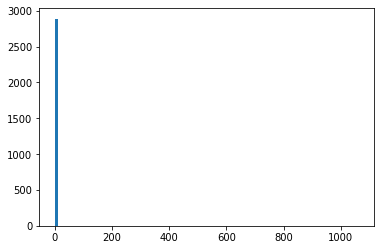

2nd Flr SF => (Mean, Standard Deviation, Skewness) = (335.45597269624574, 428.39571500882624, 0.8660131091372723)


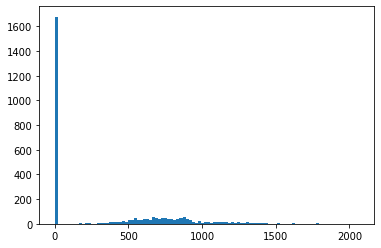

1st Flr SF => (Mean, Standard Deviation, Skewness) = (1159.5576791808874, 391.89088525349194, 1.4686762661218558)


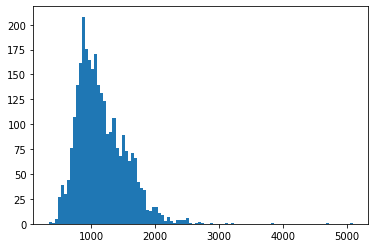

Total Bsmt SF => (Mean, Standard Deviation, Skewness) = (1051.6144217172011, 440.5398446352264, 1.1558102095862501)


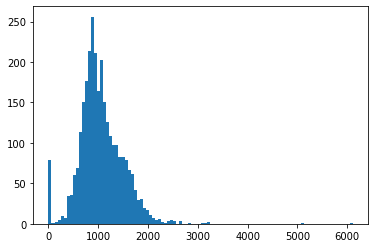

Bsmt Unf SF => (Mean, Standard Deviation, Skewness) = (559.2624817994385, 439.4191218055235, 0.9227378835744157)


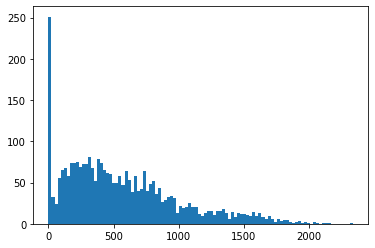

BsmtFin SF 2 => (Mean, Standard Deviation, Skewness) = (49.72242507192862, 169.13959493001585, 4.138564408427826)


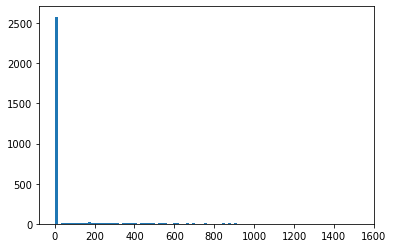

BsmtFin SF 1 => (Mean, Standard Deviation, Skewness) = (442.62951484583397, 455.51306003996496, 1.4156987950367093)


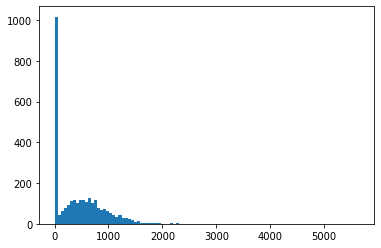

Lot Area => (Mean, Standard Deviation, Skewness) = (10147.921843003413, 7880.017759439091, 12.814333637733153)


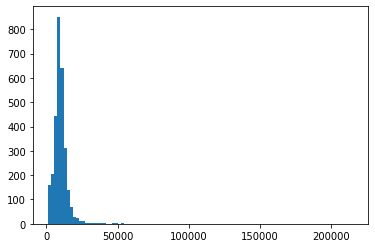

Lot Frontage => (Mean, Standard Deviation, Skewness) = (67.28853684958474, 21.754970408717526, 1.7880286306371231)


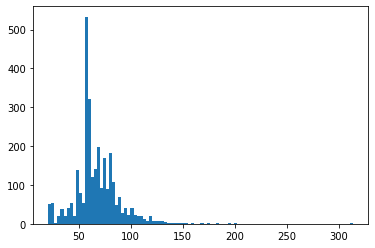

Mas Vnr Area => (Mean, Standard Deviation, Skewness) = (101.8905219629815, 178.40799681851692, 2.6160319013838182)


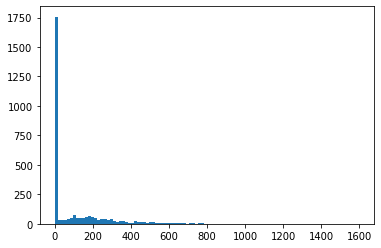


Counting Occurrances
-------------------


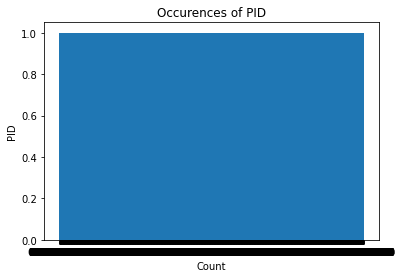

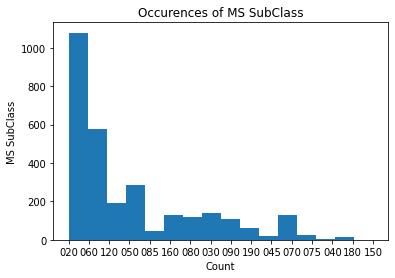

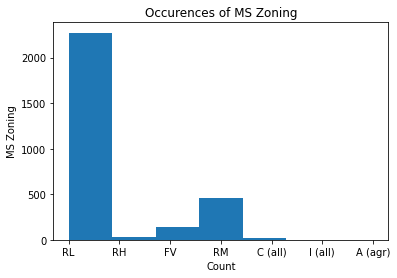

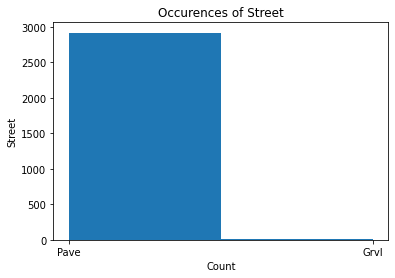

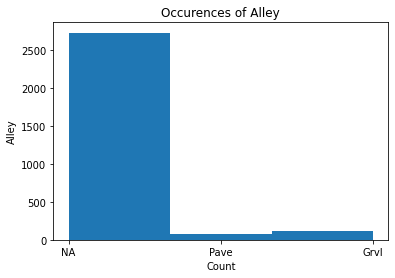

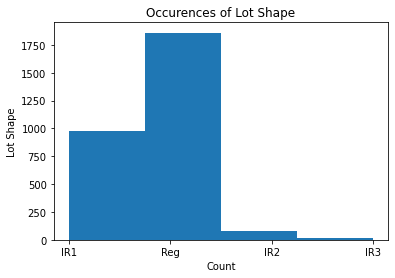

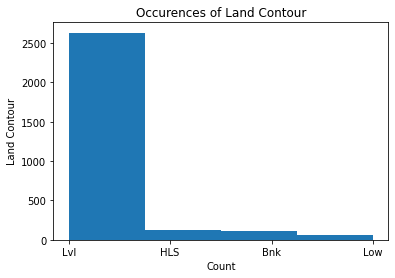

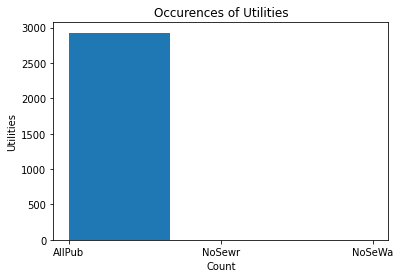

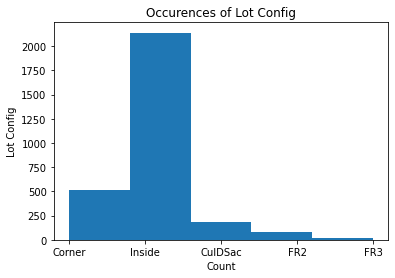

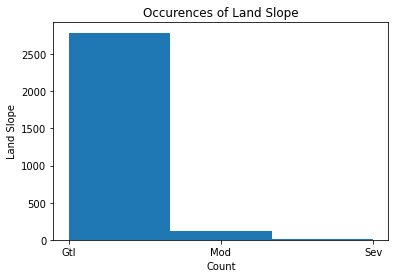

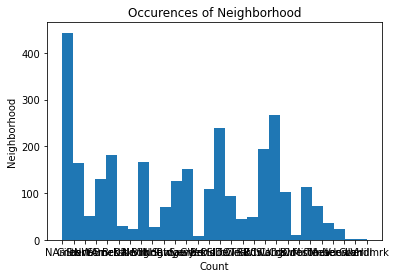

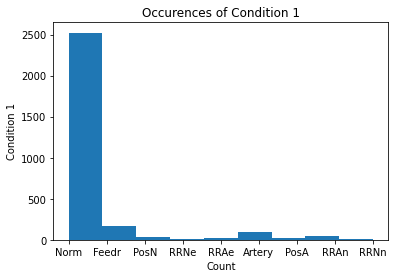

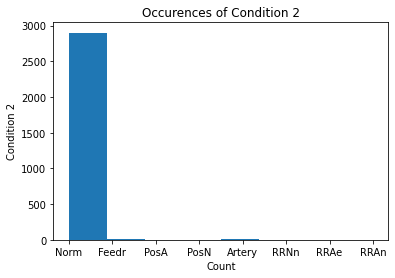

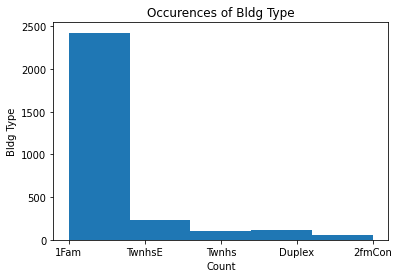

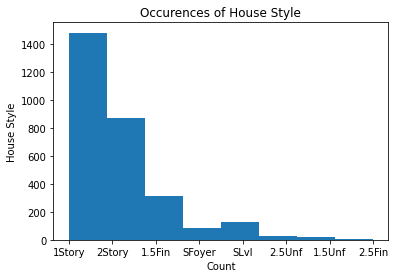

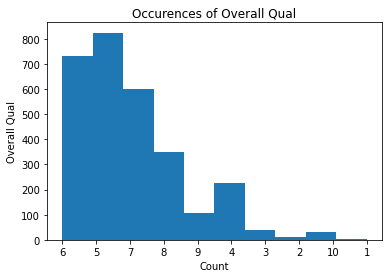

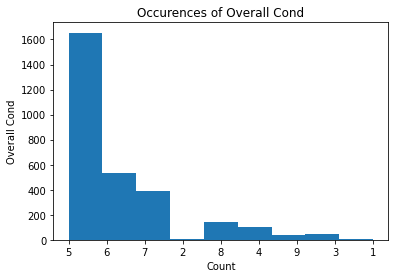

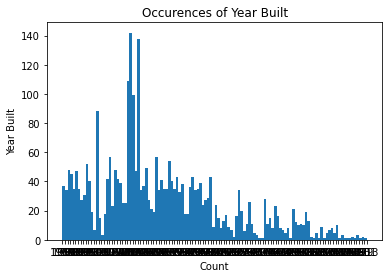

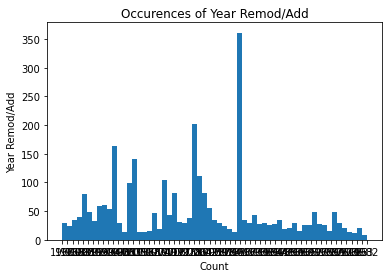

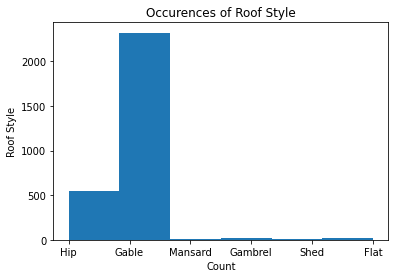

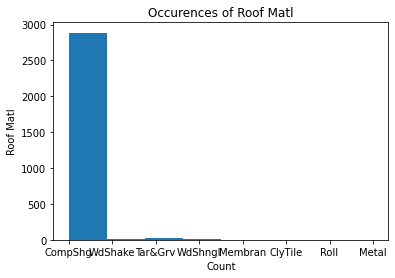

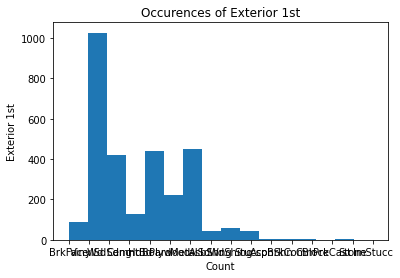

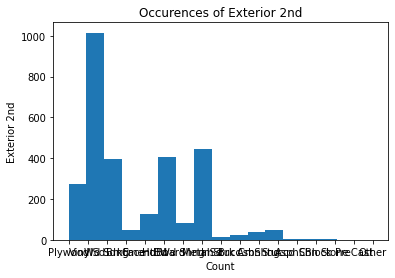

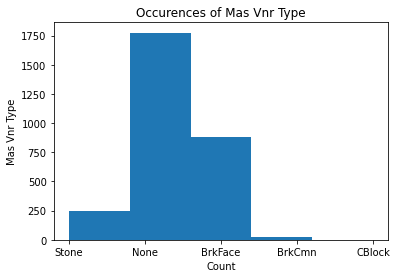

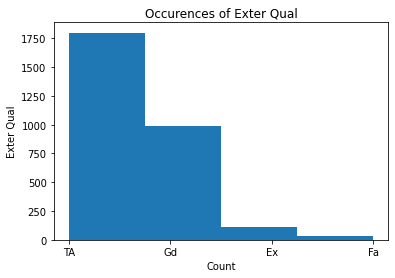

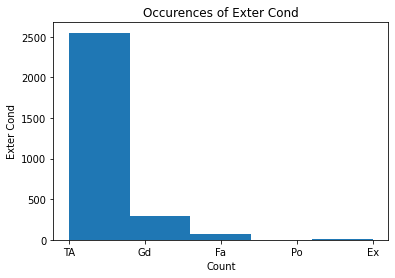

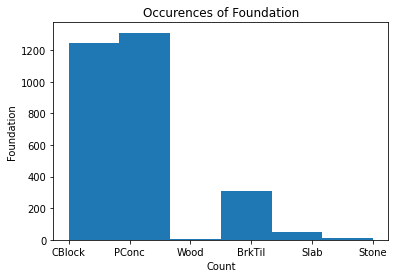

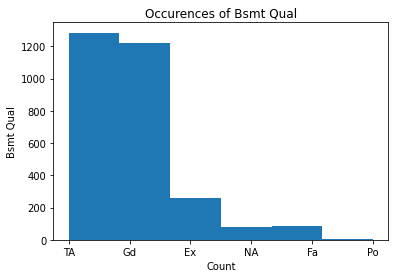

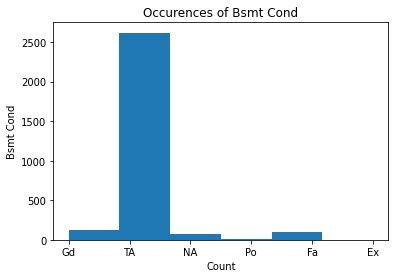

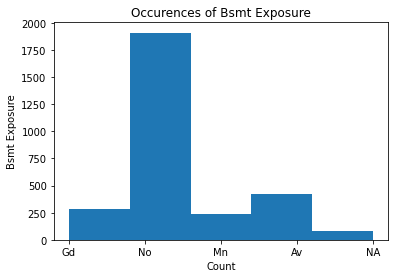

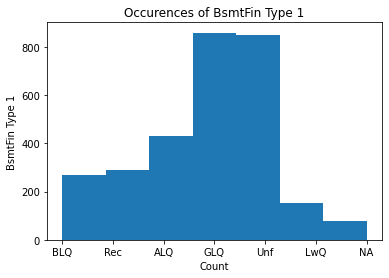

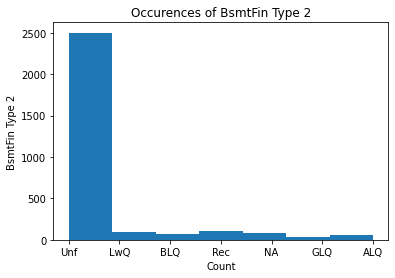

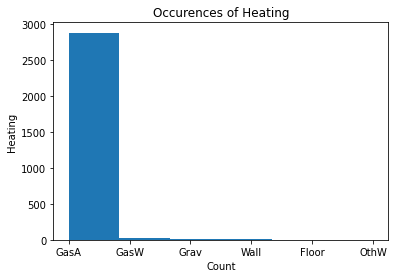

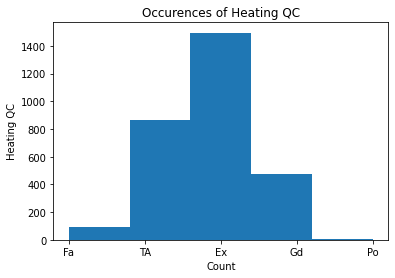

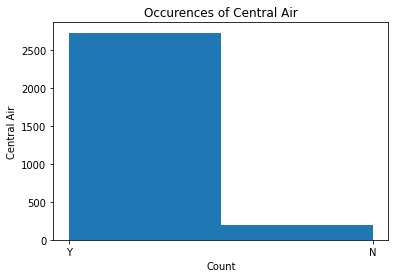

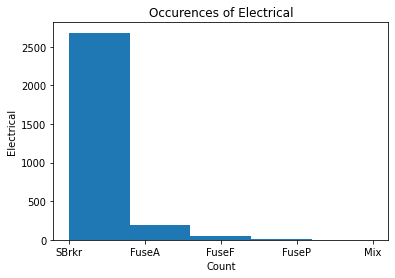

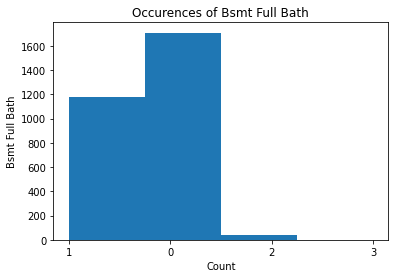

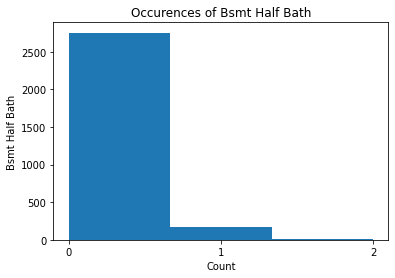

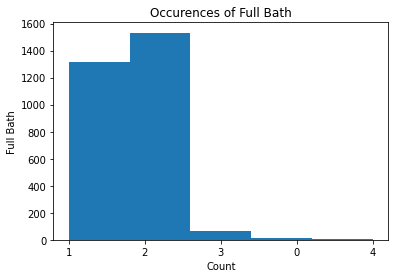

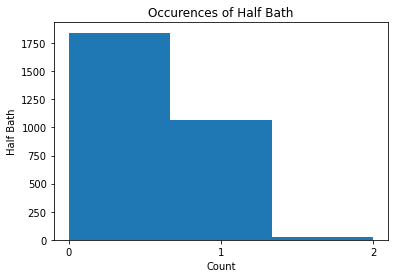

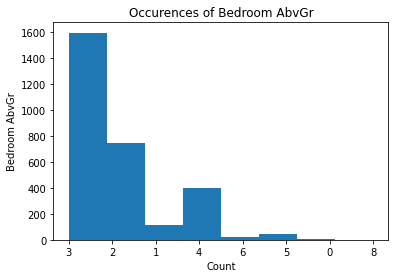

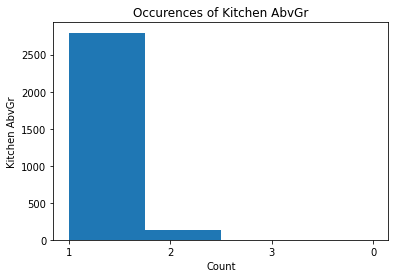

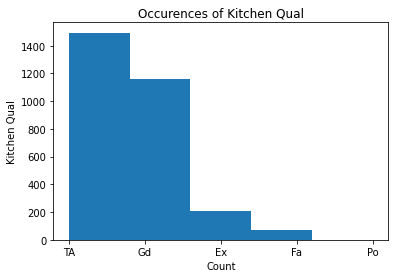

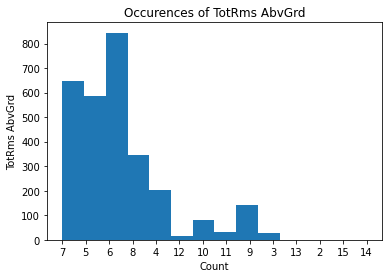

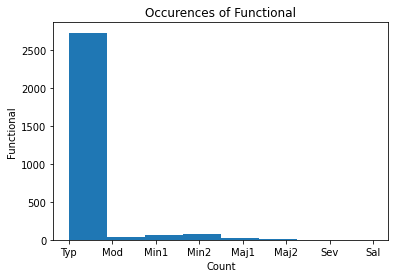

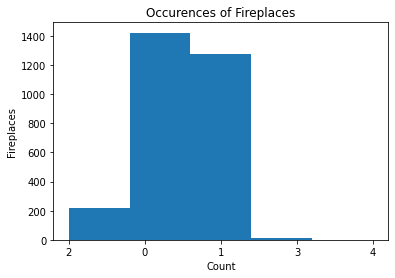

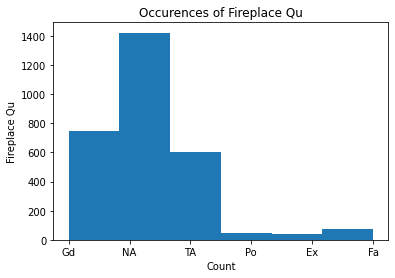

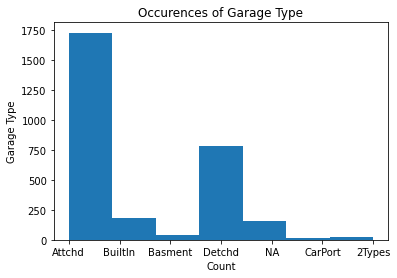

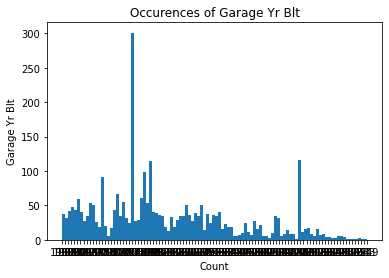

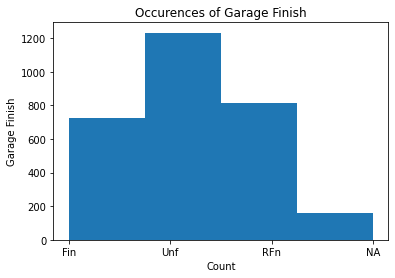

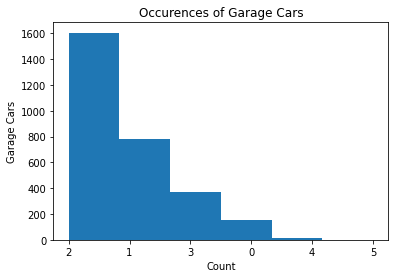

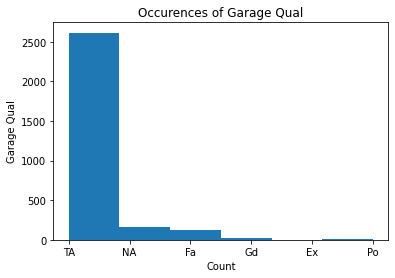

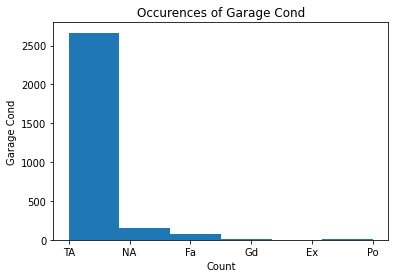

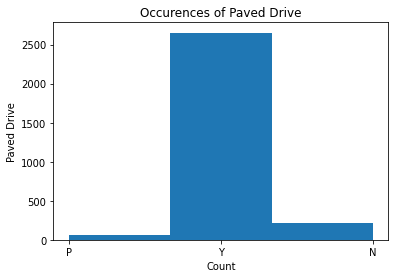

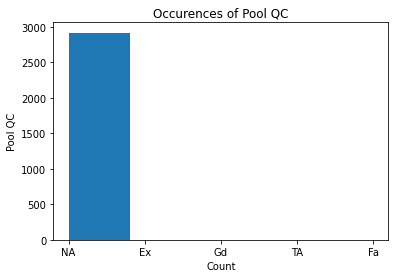

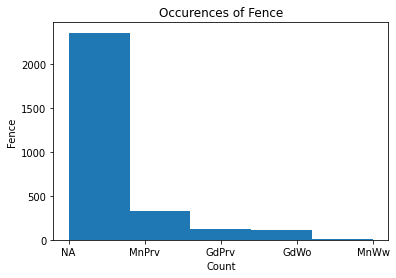

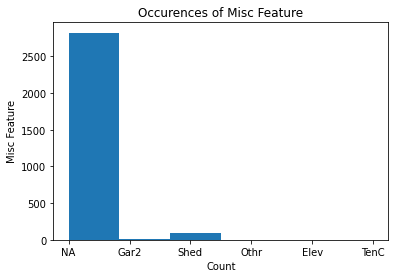

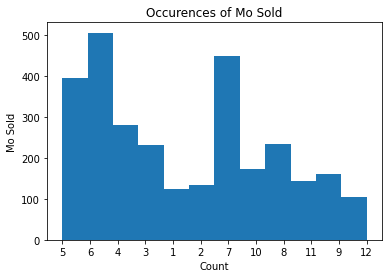

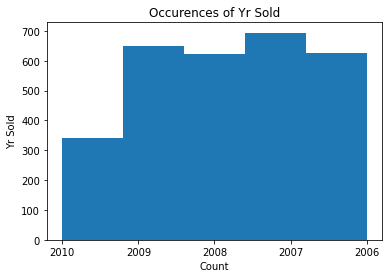

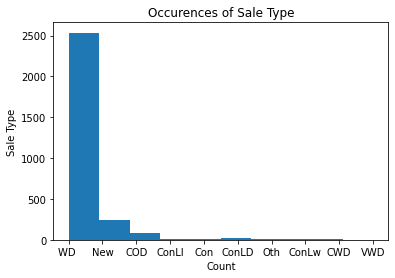

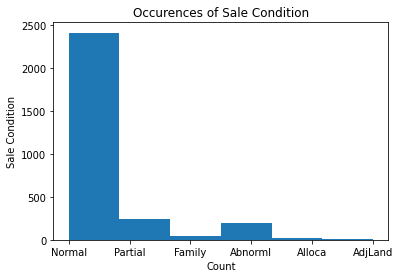

In [ ]:
#Probability Distributions.
print("Probability Distributions\n-------------------------")
for t in int_titles:
  mu, std = df[t].mean(), df[t].std()
  print("{title} => (Mean, Standard Deviation, Skewness) = ({m}, {s}, {sk})".format(title=t, m=mu, s=std, sk=skew(df[t])))
  plt.hist(df[t], bins=100)
  plt.show()


#For all of the other types of data (descrete, nominal, ordinal), we will check the number of occurrences as percentages.
titles = [t for t in df if (t in int_titles) == False and t != 'Order']
print("\nCounting Occurrances\n-------------------")
for t in titles:
  temp, counts = df[t].unique(), []
  for x in temp:
    count = 0
    for n in df[t]:
      if n == x:
        count += 1

    counts.append(count)

  plt.hist(df[t], bins=len(temp))
  plt.xlabel('Count')
  plt.ylabel(t)
  plt.title("Occurences of {ts}".format(ts=t))
  plt.show()

#Bivariate Analysis
In the following section, the code block will explore the linear regression between each variable to identify the relationships between the variables.

,SalePrice,Misc Val,Pool Area,Screen Porch,3Ssn Porch,Enclosed Porch,Open Porch SF,Wood Deck SF,Garage Area,Gr Liv Area,Low Qual Fin SF,2nd Flr SF,1st Flr SF,Total Bsmt SF,Bsmt Unf SF,BsmtFin SF 2,BsmtFin SF 1,Lot Area,Lot Frontage,Mas Vnr Area
SalePrice,1.000000,-0.015691,0.068403,0.112151,0.032225,-0.128787,0.312951,0.327143,0.640386,0.706780,-0.037660,0.269373,0.621676,0.632105,0.182805,0.005890,0.432795,0.266549,0.330098,0.505761
Misc Val,-0.015691,1.000000,0.011942,0.007162,-0.000753,0.008773,0.077254,0.056820,0.008466,0.067252,-0.005939,-0.005078,0.093003,0.083904,-0.010166,-0.005204,0.092886,0.069188,0.030119,0.044935
Pool Area,0.068403,0.011942,1.000000,0.026383,-0.006501,0.092596,0.064135,0.094156,0.053051,0.135463,0.035200,0.044602,0.121821,0.072128,-0.031999,0.044398,0.084140,0.093775,0.159340,0.004619
Screen Porch,0.112151,0.007162,0.026383,1.000000,-0.029430,-0.063965,0.047548,-0.052191,0.062435,0.086804,0.006943,0.011741,0.098316,0.075340,-0.048082,0.062950,0.095873,0.055044,0.068992,0.065632
3Ssn Porch,0.032225,-0.000753,-0.006501,-0.029430,1.000000,-0.032674,-0.009458,-0.003967,0.029458,0.006481,-0.004505,-0.032172,0.044061,0.037871,-0.005446,-0.023325,0.050541,0.016243,0.021859,0.013782
Enclosed Porch,-0.128787,0.008773,0.092596,-0.063965,-0.032674,1.000000,-0.059875,-0.119136,-0.106115,0.004030,0.087326,0.055429,-0.065713,-0.085223,0.006229,0.032379,-0.100453,0.021868,0.015929,-0.110444
Open Porch SF,0.312951,0.077254,0.064135,0.047548,-0.009458,-0.059875,1.000000,0.039243,0.232892,0.340857,-0.000761,0.184538,0.238041,0.245606,0.118870,-0.005587,0.124937,0.103760,0.144787,0.142745
Wood Deck SF,0.327143,0.056820,0.094156,-0.052191,-0.003967,-0.119136,0.039243,1.000000,0.238354,0.250153,-0.015646,0.089097,0.227131,0.229910,-0.039618,0.098518,0.223989,0.157212,0.085697,0.165116
Garage Area,0.640386,0.008466,0.053051,0.062435,0.029458,-0.106115,0.232892,0.238354,1.000000,0.484857,-0.053510,0.128578,0.491197,0.485422,0.164205,0.003317,0.309831,0.212821,0.323716,0.372254
Gr Liv Area,0.706780,0.067252,0.135463,0.086804,0.006481,0.004030,0.340857,0.250153,0.484857,1.000000,0.097050,0.655251,0.562166,0.444567,0.235416,-0.018116,0.209582,0.285599,0.334350,0.402637


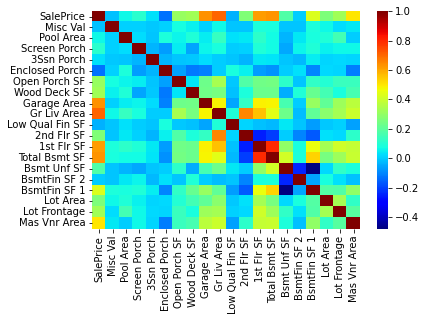

In [ ]:
new_ints = [t for t in int_titles if (len(temporary[t].unique()) == 1 and temporary[t].unique()[0] == 0.0) == False]
sns.heatmap(temporary[new_ints].corr(), cmap='jet')

temporary[new_ints].corr()

Using the correlation values, the following block will look at the columns will correlation values above 0.5. Using the Entropy equation from the Decision Tree model, the dataset can be split to find which variables would discribe the variables the best.

An example that may occur would be splitting on Year or Month Sold which allows the relationships between the continuous variables to be explored more thoroughly.


Using the Information Gain equation from the Decision Tree technique, each Nomial (and Ordinal etc) columns will have it applied to them to identify which column should be used for splitting the 

[[237.93462194]]
[[111.69400086]]
[[114.62485385]]
Standard Deviation (2010): (Sale Price, Garage Area) = (74631.4313083648, 197.0245818540226)
Standard Deviation (2009): (Sale Price, Garage Area) = (80856.80430109256, 217.34893248770808)
Standard Deviation (2008): (Sale Price, Garage Area) = (75592.73653419659, 227.07386836555526)
Standard Deviation (2007): (Sale Price, Garage Area) = (82542.77462863794, 215.56067075803008)
Standard Deviation (2006): (Sale Price, Garage Area) = (82619.69785337095, 208.07913876634436)

Mode (2010): (Sale Price, Garage Area) = ([128000.0, 155000.0, 190000.0], [0.0])
Mode (2009): (Sale Price, Garage Area) = ([135000.0], [0.0])
Mode (2008): (Sale Price, Garage Area) = ([140000.0], [0.0])
Mode (2007): (Sale Price, Garage Area) = ([130000.0], [0.0])
Mode (2006): (Sale Price, Garage Area) = ([137000.0, 140000.0], [0.0])

Mean (2010): (Sale Price, Garage Area) = (172597.5982404692, 450.5131964809384)
Mean (2009): (Sale Price, Garage Area) = (181404.5679012345

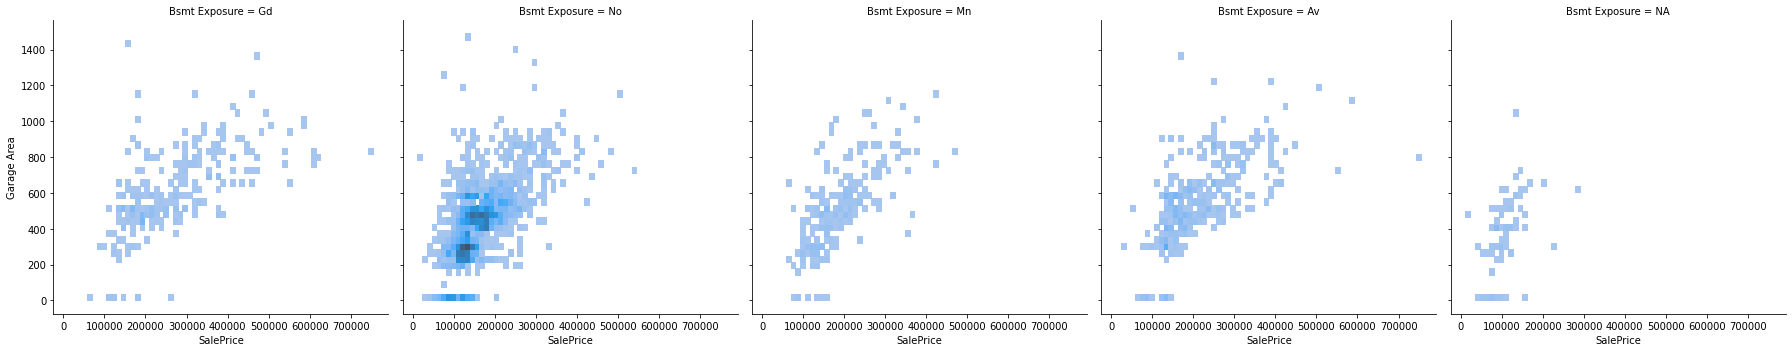

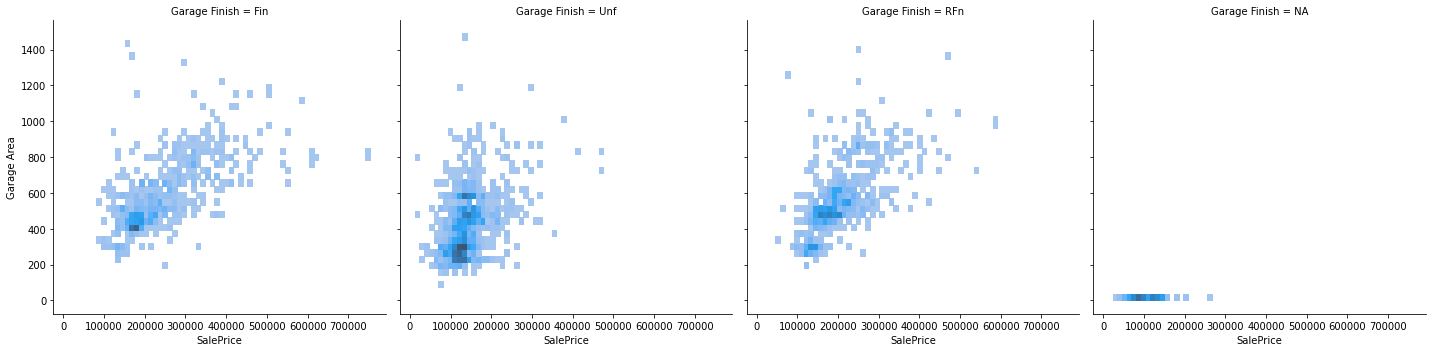

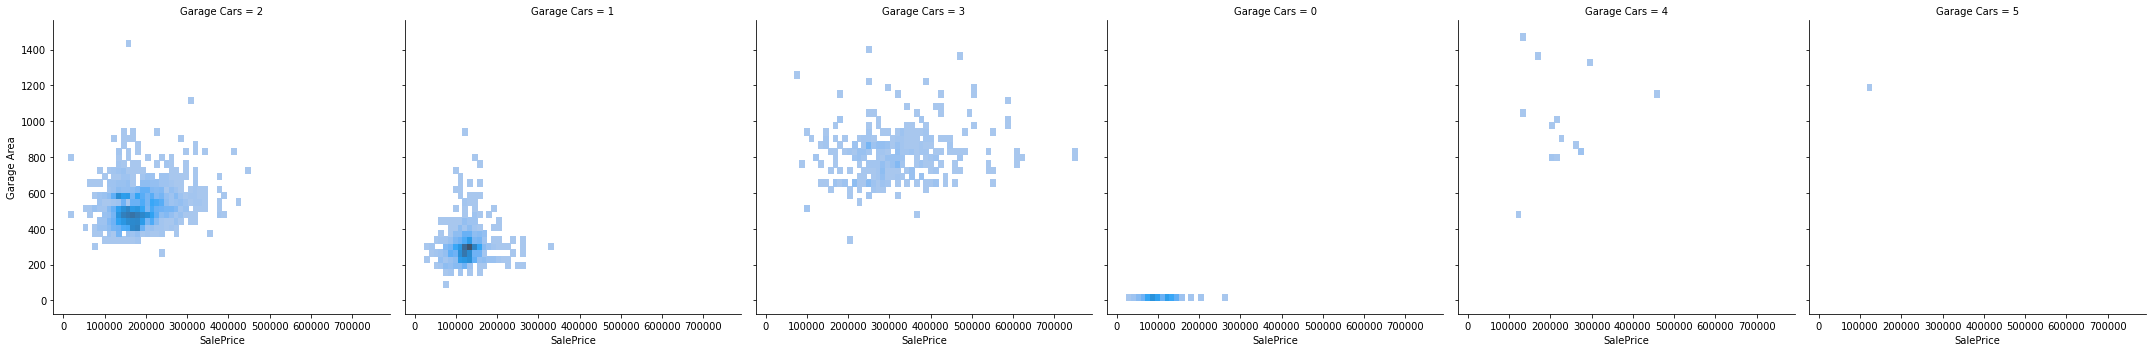

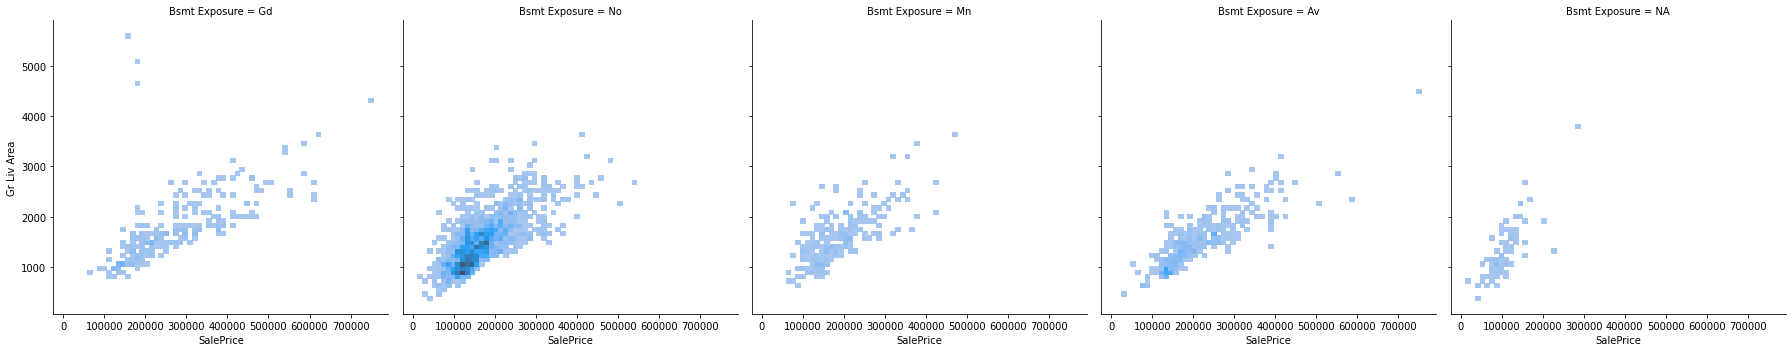

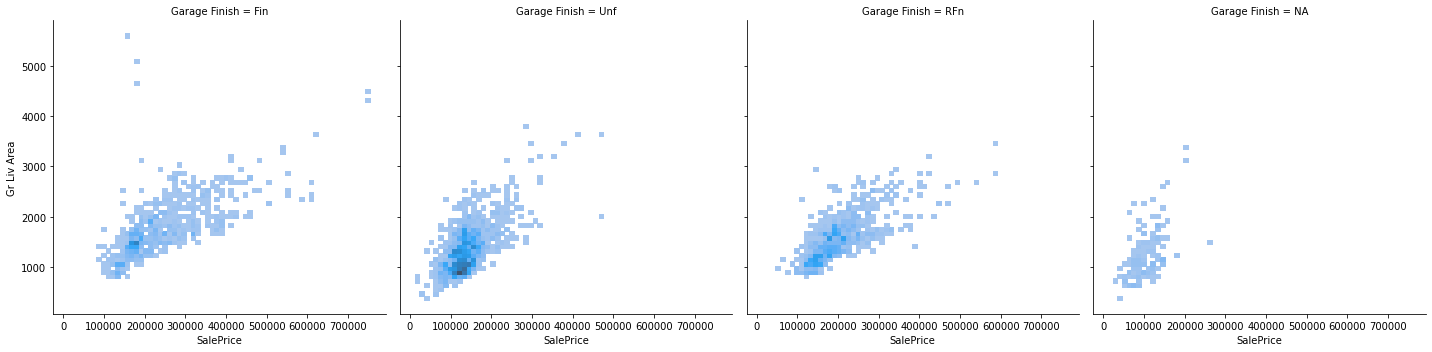

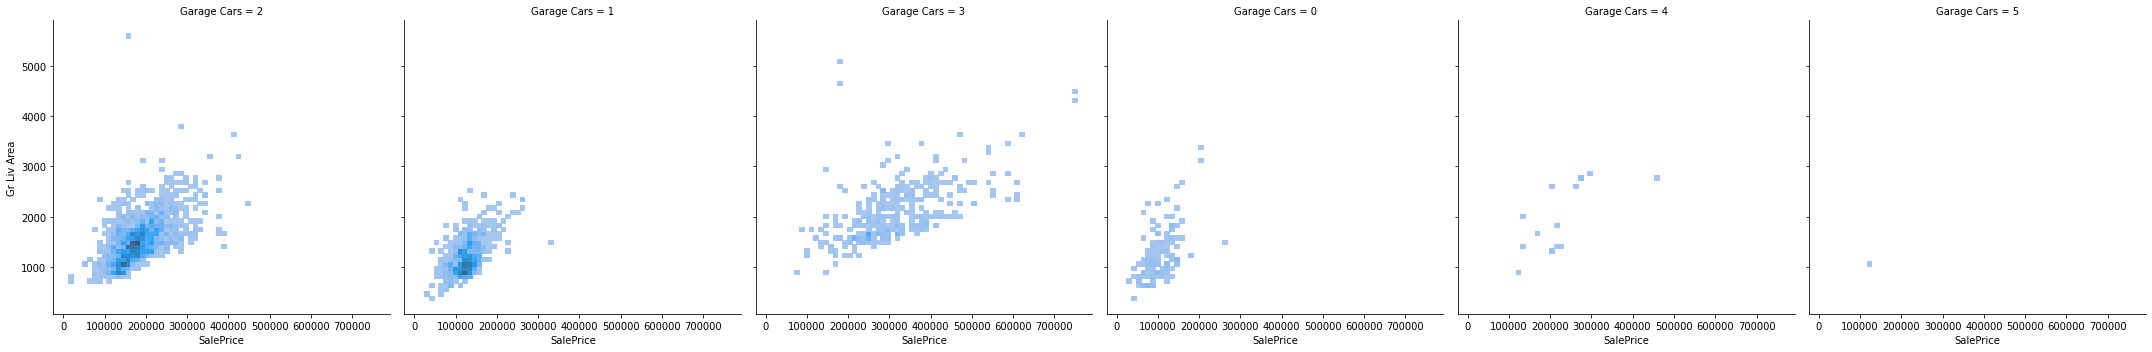

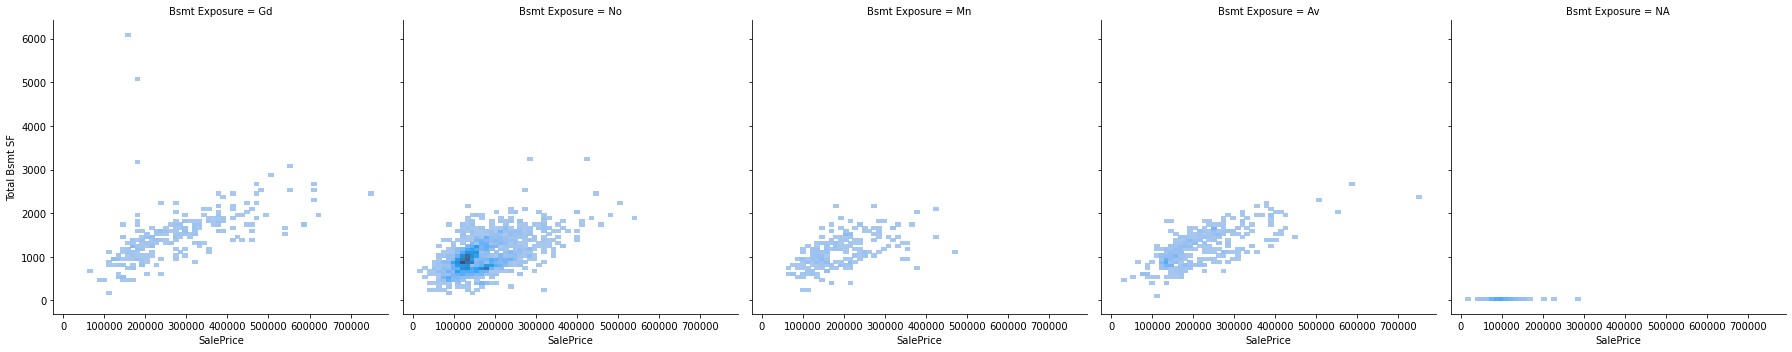

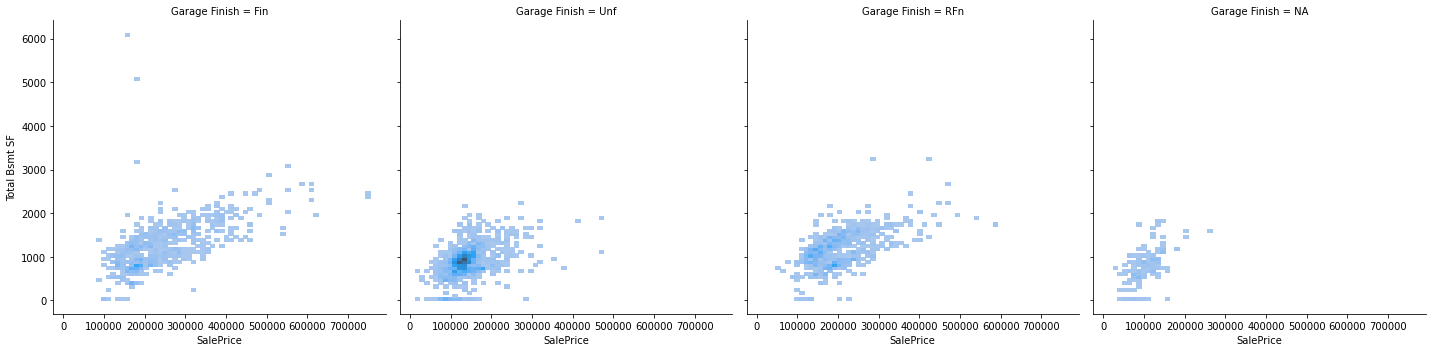

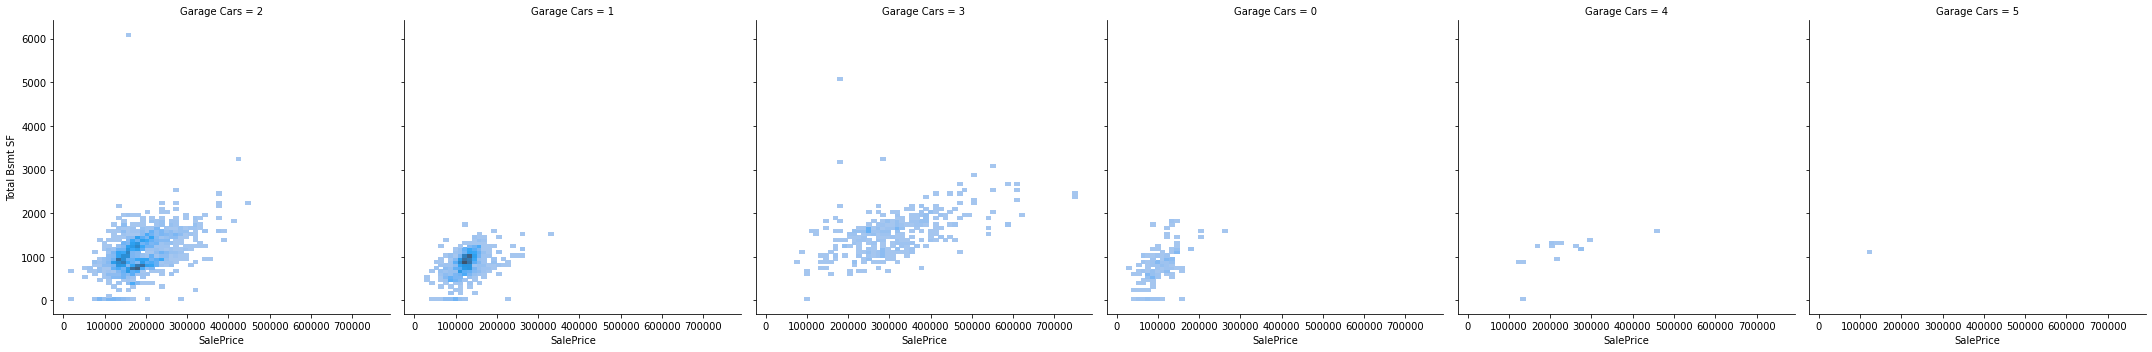

In [ ]:
from sklearn.linear_model import LinearRegression

#Calculate the Linear Regression for each variable with respect to 'SalePrice'.
for t in ['Garage Area', 'Gr Liv Area','Total Bsmt SF']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['SalePrice'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['Garage Area', 'Gr Liv Area', 'Total Bsmt SF']:
  for y in temporary['Yr Sold'].unique():
    #Find the subset of the data based on the year.
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', 'SalePrice', t]]

    #Find the variance along the linear regression.
    std1, std2 = temp['SalePrice'].std(), temp[t].std()
    print("Standard Deviation ({yr}): (Sale Price, {ti}) = ({s1}, {s2})".format(yr=y, ti=t, s1=std1, s2=std2))
  print("")
  
  n = 'SalePrice'
  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', n, t]]

    mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
    print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='Sale Price', ti=t, m1=mode1, m2=mode2))
  print("")

  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', n, t]]

    mean1, mean2 = temp[n].mean(), temp[t].mean()
    print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='Sale Price', ti=t, m1=mean1, m2=mean2))
  print("")


for _x in ['Garage Area', 'Gr Liv Area', 'Total Bsmt SF']:
  for _y in ['Bsmt Exposure', 'Garage Finish', 'Garage Cars']:
    sns.displot(temporary, x='SalePrice', y=_x, col=_y)

Looking at the Gr Liv Area and SalePrice relationship, it can be seen that there is a positive linear relationship between the variables. This shows that the more above ground living area the household has, the SalePrice increases for the household.

Looking at the SalePrice and Total Bsmt SF relationship split by the Basement exposure, it can be seen that there were more households sold where there is no exposure. It can also be seen that there is still a linear relationship between these variables, but with a larger variance when compared to the other relationships explored in the above code.

This higher density of no basement exposure is likely related to the privacy of the occupants and the positive linear relationship shows that the higher the square footage of the basement (much like the Garage) increases the price of the household.

Looking at the Garage Area and SalePrice relationship, it can be seen that increasing the Garage Area increases the SalePrice of the household whilst similtaneously increasing the the variance. This means that a garage that has more room will increase the SalePrice of the household.

When this relationship is split by the Garage Fin column, it can be seen that when the Garage is unfinished it will reduce the value of the household. This is not the case however for a finished and roughly finished garage as they both have a higher average sale price and steeper gradient (higher correlation).

When looking at the same relationship but split by the number of cars that can be in the garage, it can be seen that the larger area a garage has, the more cars it can fit in it. This also holds with the sale price as well; Where the number of cars increase, the sale price of the household increases as well.



[[0.77319937]]
Standard Deviation (2010): (Gr Liv Area, 2nd Flr SF) = (466.3315218117837, 409.8168370558351)
Standard Deviation (2009): (Gr Liv Area, 2nd Flr SF) = (464.3835039850644, 420.55389559725677)
Standard Deviation (2008): (Gr Liv Area, 2nd Flr SF) = (510.55317372302943, 421.9168103265708)
Standard Deviation (2007): (Gr Liv Area, 2nd Flr SF) = (552.9855806751177, 439.65614324604826)
Standard Deviation (2006): (Gr Liv Area, 2nd Flr SF) = (506.7681132937254, 440.3449656861405)
Mode (2010): (Gr Liv Area, 2nd Flr SF) = ([128000.0, 155000.0, 190000.0], [0.0])
Mode (2009): (Gr Liv Area, 2nd Flr SF) = ([135000.0], [0.0])
Mode (2008): (Gr Liv Area, 2nd Flr SF) = ([140000.0], [0.0])
Mode (2007): (Gr Liv Area, 2nd Flr SF) = ([130000.0], [0.0])
Mode (2006): (Gr Liv Area, 2nd Flr SF) = ([137000.0, 140000.0], [0.0])

Mean (2010): (Gr Liv Area, 2nd Flr SF) = (172597.5982404692, 320.0351906158358)
Mean (2009): (Gr Liv Area, 2nd Flr SF) = (181404.56790123458, 327.0987654320988)
Mean (2008): (G

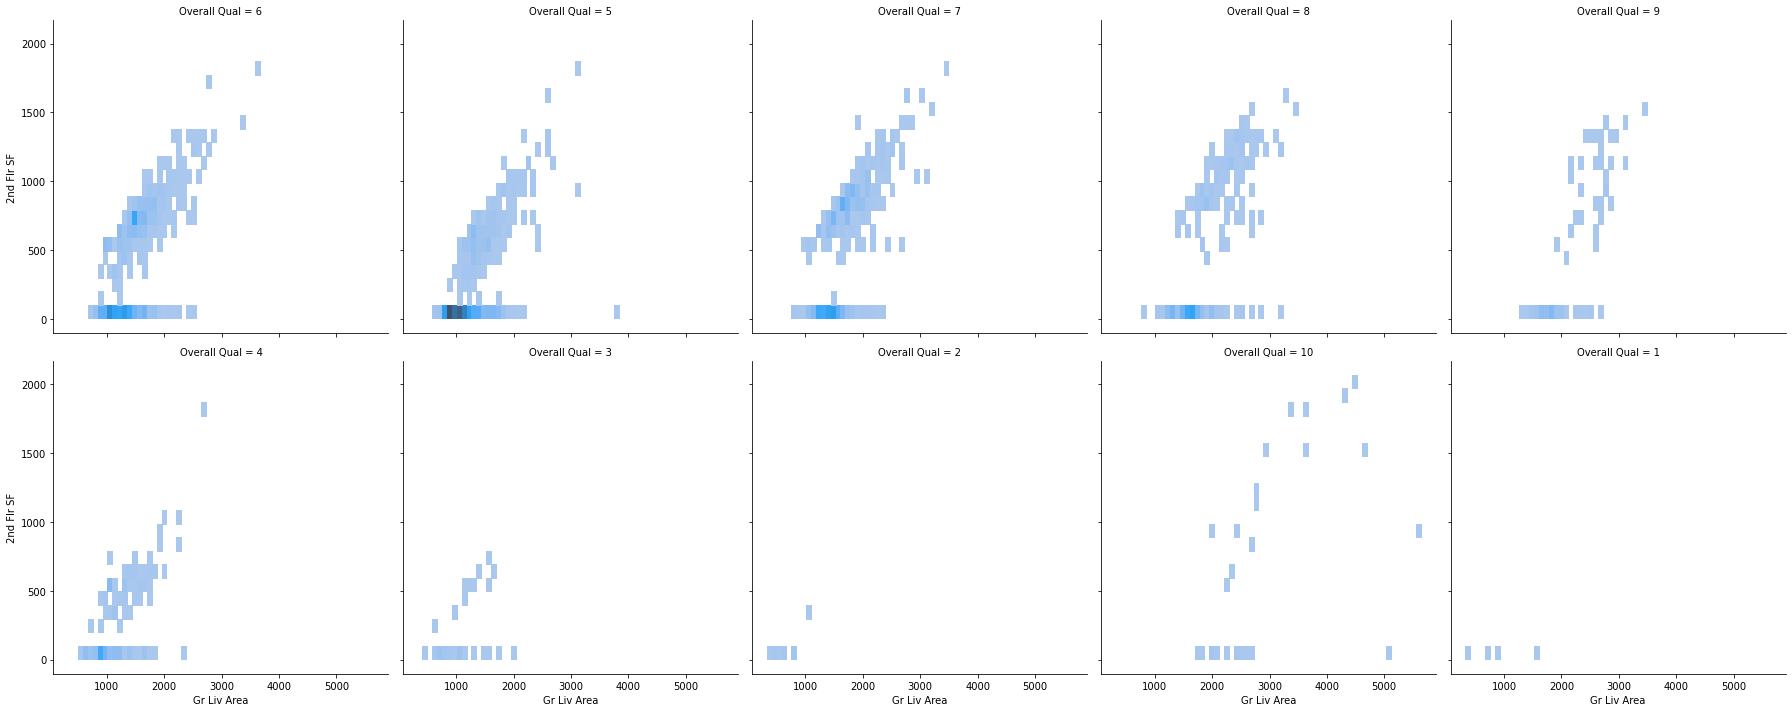

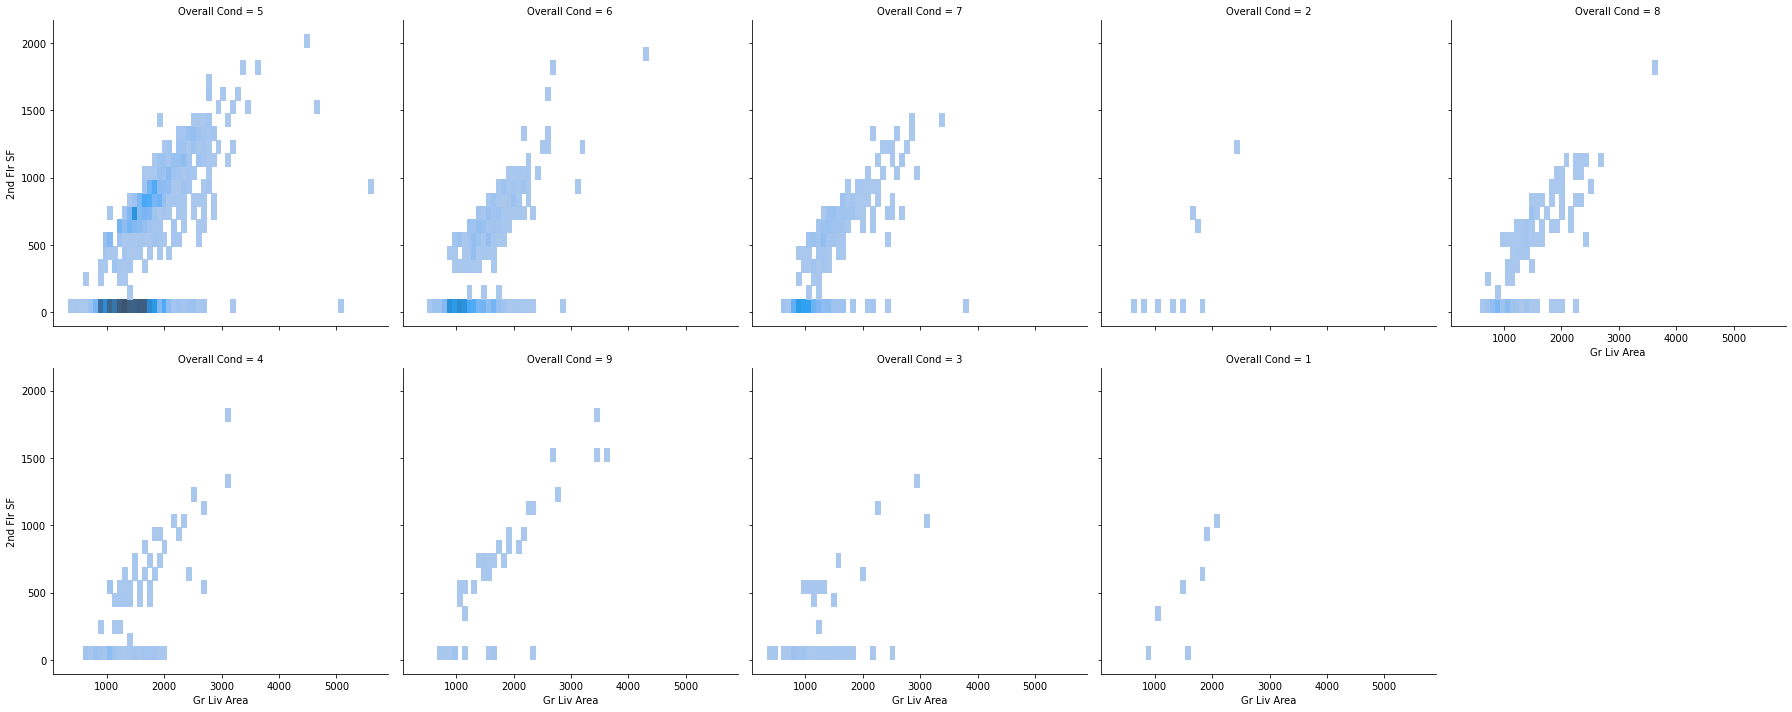

In [ ]:
#Calculate the Linear Regression for each variable with respect to 'Gr Liv Area'.
for t in ['2nd Flr SF']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['Gr Liv Area'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['2nd Flr SF']:
  for y in temporary['Yr Sold'].unique():
    #Find the subset of the data based on the year.
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', 'Gr Liv Area', t]]

    #Find the variance along the linear regression.
    std1, std2 = temp['Gr Liv Area'].std(), temp[t].std()
    print("Standard Deviation ({yr}): (Gr Liv Area, {ti}) = ({s1}, {s2})".format(yr=y, ti=t, s1=std1, s2=std2))

  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', n, t]]

    mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
    print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='Gr Liv Area', ti=t, m1=mode1, m2=mode2))
  print("")

  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', n, t]]

    mean1, mean2 = temp[n].mean(), temp[t].mean()
    print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='Gr Liv Area', ti=t, m1=mean1, m2=mean2))
  print("")

for _x in ['2nd Flr SF']:
  for _y in ['Overall Qual', 'Overall Cond']:
    sns.displot(temporary, x='Gr Liv Area', y=_x, col=_y, col_wrap=5)

Looking at the relationship that has been split by the Overall quality of the household, it can be seen that the Gr Liv Area variable's mean increases, which is the same for the 2nd Flr SF variable. This suggests that as the 2nd Floor's Square Footage and the size of the above ground living area increases, the quality of the household increases with it.

There is no such trend for the Overall Condition, however it can be seen that there is still a positive linear relationship between the variables and that the majority of the households that have been sold have a Overall Condition between 5 and 8.

[[0.71224172]]
Standard Deviation (2010): (1st Flr SF, Total Bsmt SF) = (370.5678086774598, 406.1186636310336)
Standard Deviation (2009): (1st Flr SF, Total Bsmt SF) = (387.51044833099377, 463.8545486090939)
Standard Deviation (2008): (1st Flr SF, Total Bsmt SF) = (402.1094683609374, 450.87840767452315)
Standard Deviation (2007): (1st Flr SF, Total Bsmt SF) = (423.73076548419874, 456.1269160431717)
Standard Deviation (2006): (1st Flr SF, Total Bsmt SF) = (358.04137622232923, 404.1189175198755)
Mode (2010): (1st Flr SF, Total Bsmt SF) = ([600.0, 864.0], [864.0])
Mode (2009): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0])
Mode (2008): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0, 864.0])
Mode (2007): (1st Flr SF, Total Bsmt SF) = ([1040.0], [0.0])
Mode (2006): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0])

Mean (2010): (1st Flr SF, Total Bsmt SF) = (1132.7595307917888, 1040.6304985337244)
Mean (2009): (1st Flr SF, Total Bsmt SF) = (1169.125, 1051.2345679012346)
Mean (2008): (1st Flr SF,

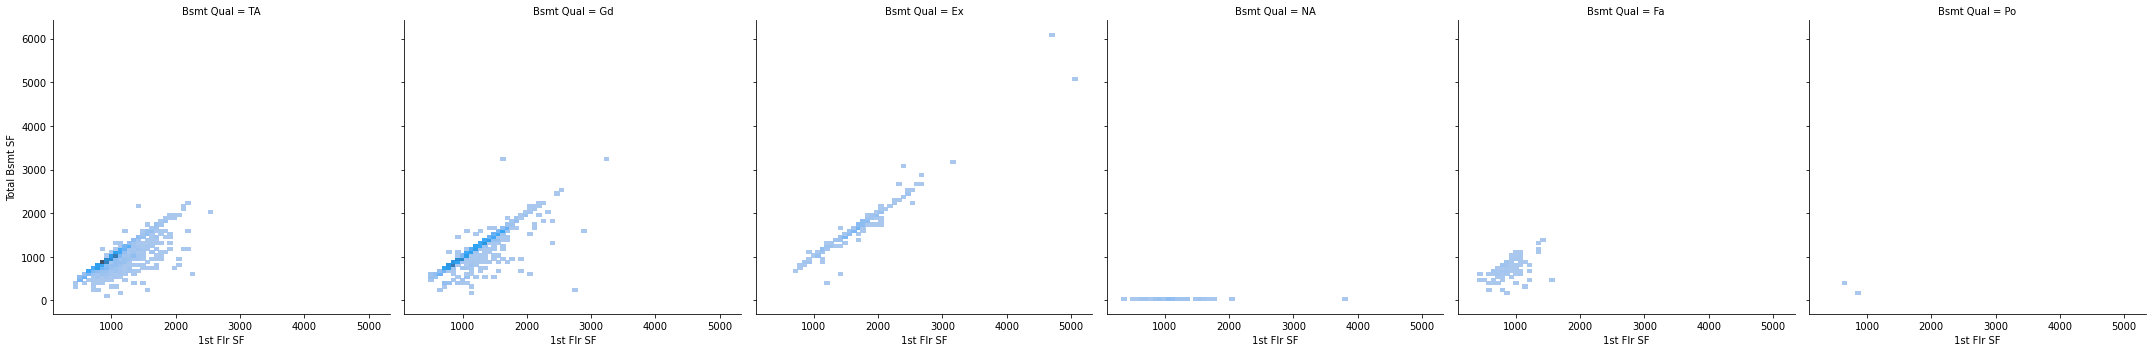

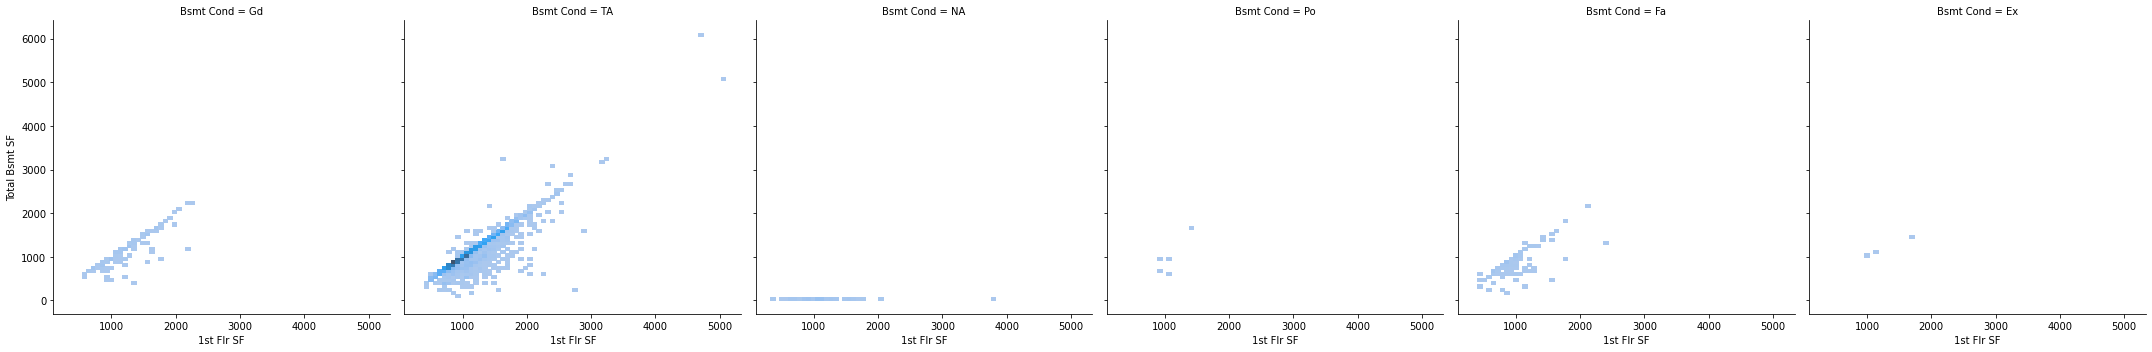

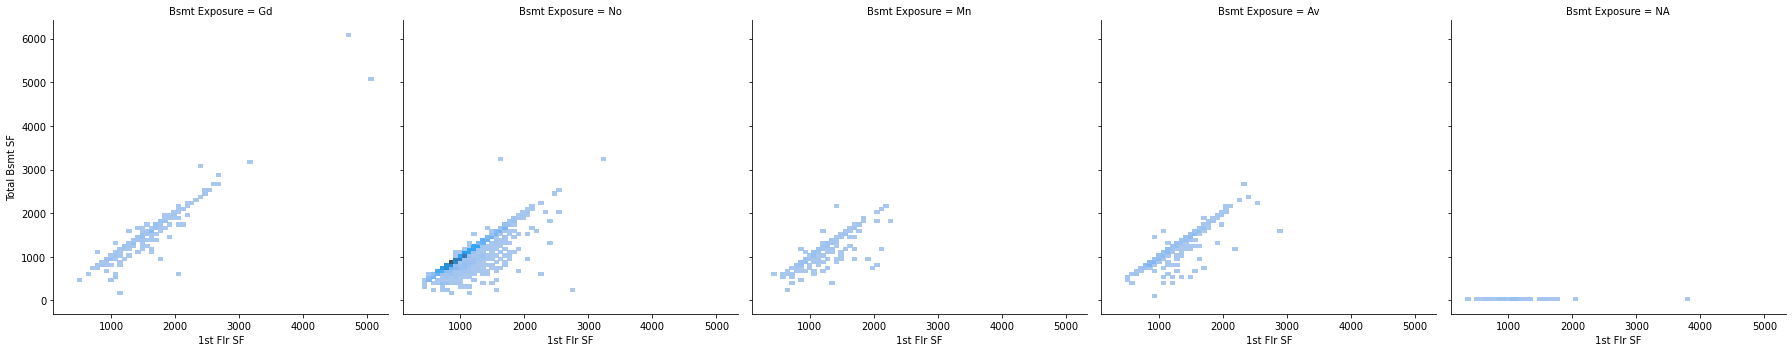

In [ ]:
#Calculate the Linear Regression for each variable with respect to '1st Flr SF'.
for t in ['Total Bsmt SF']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['1st Flr SF'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['Total Bsmt SF']:
  for y in temporary['Yr Sold'].unique():
    #Find the subset of the data based on the year.
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', '1st Flr SF', t]]

    #Find the variance for this.
    std1, std2 = temp['1st Flr SF'].std(), temp[t].std()
    print("Standard Deviation ({yr}): (1st Flr SF, {ti}) = ({s1}, {s2})".format(yr=y, ti=t, s1=std1, s2=std2))

  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', '1st Flr SF', t]]

    mode1, mode2 = [a for a in temp['1st Flr SF'].mode()], [a for a in temp[t].mode()]
    print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='1st Flr SF', ti=t, m1=mode1, m2=mode2))
  print("")

  for y in temporary['Yr Sold'].unique():
    temp = temporary[temporary['Yr Sold'] == str(y)]
    temp = temp[['Yr Sold', '1st Flr SF', t]]

    mean1, mean2 = temp['1st Flr SF'].mean(), temp[t].mean()
    print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni='1st Flr SF', ti=t, m1=mean1, m2=mean2))
  print("")

#Strong linear relationship, especially for good and average quality, average condition and no exposure.
for _x in ['Total Bsmt SF']:
  for _y in ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure']:
    sns.displot(temporary, x='1st Flr SF', y=_x, col=_y)

Looking at the above visualizations, it can be seen that there is a strong positive linear relationship between the square footage of the 1st floor and the square footage of the basement with some minor variance.

Splitting this relationships by the Nominal columns relating to the basement, it can be seen an average quality and condition shares the same level of variance as well as density where the basement does not have any exposure.

In the following code blocks, the variables which has a correlation less than 0 will be analysed. Using the Entropy equation from the Decision Tree model, the dataset can be split to find which variables would discribe the variables the best.

An example that may occur would be splitting on Year or Month Sold which allows the relationships between the continuous variables to be explored more thoroughly.

In [ ]:
#Calculate the Linear Regression for each variable with respect to 'Open Porch SF'.
for t in ['BsmtFin SF 1']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['Open Porch SF'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['BsmtFin SF 1']:
  for x in ['Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure']:
    for y in temporary[x].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Open Porch SF', t]]

      #Find the variance for this.
      std1, std2 = temp['Open Porch SF'].std(), temp[t].std()
      print("Standard Deviation ({yr}): (Open Porch SF, {ti}) = ({s1}, {s2})".format(yr=x, ti=t, s1=std1, s2=std2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Open Porch SF', t]]

      mode1, mode2 = [a for a in temp['Open Porch SF'].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni='Open Porch SF', ti=t, m1=mode1, m2=mode2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Open Porch SF', t]]

      mean1, mean2 = temp['Open Porch SF'].mean(), temp[t].mean()
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni='Open Porch SF', ti=t, m1=mean1, m2=mean2))
    print("")

#Visualize the splits in the data.


[[0.01850913]]
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (65.66963748254189, 460.691073579365)
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (67.90370196335095, 457.74498017050206)
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (59.534254770462404, 0.0)
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (85.86501033599193, 448.75917817912085)
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (57.80388979238936, 333.19517038006484)
Standard Deviation (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (51.96152422706632, 163.77118183612157)

Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Cond): (Open Porch SF, BsmtFin SF 1) = (

Looking at the linear regression between BsmtFin SF 1 and Open Porch SF has a very small negative relationship, this shows that the square footage of a finished basement is inversely proportional (to a small degree) to the square footage of the Open Porch. However, due to such a large amount of variance within the data (which can be seen in the standard devition for each BsmtFin SF 1), it is very likely the case that there is no significance solely between these variables. For that reason, this relationship will be explored further in the Multivariate Section.

In [ ]:
#Calculate the Linear Regression for each variable with respect to 'Wood Deck SF'.
for t in ['Bsmt Unf SF']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['Wood Deck SF'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['Bsmt Unf SF']:
  for x in ['Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure']:
    for y in temporary[x].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Wood Deck SF', t]]

      #Find the variance for this.
      std1, std2 = temp['Wood Deck SF'].std(), temp[t].std()
      print("Standard Deviation ({yr}): (Wood Deck SF, {ti}) = ({s1}, {s2})".format(yr=x, ti=t, s1=std1, s2=std2))
    print("")

    n = 'Wood Deck SF'
    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

[[-0.01139265]]
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (149.9878884601389, 472.58290126059387)
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (126.41549912622666, 436.5857650903988)
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (73.50003477534301, 0.0)
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (71.55417527999327, 262.6242563054677)
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (91.72970194446297, 357.7395712267635)
Standard Deviation (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = (161.65807537309522, 120.93524438034322)

Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [333.0, 600.0, 610.0, 936.0, 961.0])
Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (Bsmt Cond): (Wood Deck SF, Bsmt Unf 

Looking at the relatively small gradient/correlation of the linear model (slight above a -1/10) between the square footage of unfinished basement and the square footage of a wooden deck, it can be seen that the more unfinished the basement is, the less amount of space there is for the Wooden Deck. 

However, much like the previous relationship in the above code block, due to the relationship having such a small correlation, it will need to be explored further in the Multivariate section of this Notebook to uncover why it has a negative relationship.

In [ ]:
#Calculate the Linear Regression for each variable with respect to 'Gr Liv Area'
for t in ['BsmtFin SF 1']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['Gr Liv Area'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['BsmtFin SF 1']:
  for x in ['Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure']:
    for y in temporary[x].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Gr Liv Area', t]]

      #Find the variance for this.
      std1, std2 = temp['Gr Liv Area'].std(), temp[t].std()
      print("Standard Deviation ({yr}): (Gr Liv Area, {ti}) = ({s1}, {s2})".format(yr=x, ti=t, s1=std1, s2=std2))
    print("")

    n = 'Gr Liv Area'
    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

[[0.23258509]]
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (480.4274928337035, 460.691073579365)
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (504.14749748918365, 457.74498017050206)
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (544.8550864574534, 0.0)
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (340.51093961868537, 448.75917817912085)
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (518.440912218823, 333.19517038006484)
Standard Deviation (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = (353.10621631458145, 163.77118183612157)

Mode (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = ([1200.0], [0.0])
Mode (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = ([864.0], [0.0])
Mode (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = ([1040.0], [0.0])
Mode (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = ([904.0, 1077.0, 1418.0, 1601.0, 1701.0], [0.0])
Mode (Bsmt Cond): (Gr Liv Area, BsmtFin SF 1) = ([1308.0], [0.0])
Mode (Bsmt Cond): (Gr Liv A

Looking at the correlation/gradient of this relationship between the BsmtFin SF 1 and Gr Liv Area variables, it can be said that as BsmtFin SF 1 increases, that the above ground living area (Gr Liv Area) decreases slightly.

However, there is a similar issue to the 2 previous relationship. That is that the correlation between these variables are so small, that there has to be a set of variables within the dataset that are not accounted for that causes this negative linear relationship. This will again be explored in the multivariate section of this notebook.

In [ ]:
#Calculate the Linear Regression for each variable with respect to '2nd Flr SF'.
for t in ['BsmtFin SF 1', '1st Flr SF', 'Bsmt Unf SF', 'Total Bsmt SF']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['2nd Flr SF'].to_numpy().reshape(-1, 1))

  print(m.coef_)

#Find the statisical information about the given columns.
for t in ['BsmtFin SF 1', '1st Flr SF', 'Bsmt Unf SF', 'Total Bsmt SF']:
  for x in ['Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual']:
    for y in temporary[x].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, '2nd Flr SF', t]]

      #Find the variance for this.
      std1, std2 = temp['2nd Flr SF'].std(), temp[t].std()
      print("Standard Deviation ({yr}): (2nd Flr SF, {ti}) = ({s1}, {s2})".format(yr=x, ti=t, s1=std1, s2=std2))
    print("")

    n = '2nd Flr SF'
    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

[[-0.15423333]]
[[-0.27335015]]
[[0.00193056]]
[[-0.19966368]]
Standard Deviation (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (453.2625803050839, 626.8832824504544)
Standard Deviation (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (418.23999480218816, 371.87024443165956)
Standard Deviation (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (449.548891908742, 417.8818734434369)
Standard Deviation (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (416.73132414465255, 448.9194070656071)
Standard Deviation (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (381.8624688911957, 0.0)

Mode (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])

Mean (Bsmt Exposure): (2nd Flr SF, BsmtFin SF 1) = (221.77464788732394, 936.2147887323944)
Mean (

Looking at the relationship between the BsmtFin SF 1 and the 2nd Flr SF, it can be seen that there is a relatively strong negative relationship compared to the other relationship in the above code blocks. This would suggest  that the 2nd Floor tends to be smaller when the finished basement has a large size.

However, as it can be seen in the standard deviation, between these variables it can be seen that they both have a large standard deviation meaning that whilst they do have a tendancy to be inversely related, there is still a chance that the opposite is true or that they have the same size etc.

Looking at the relationship between the square footage of the 1st and 2nd Floor, it can be seen that this currently the strongest negative relationship that has been covered so far. This relationship shows that for the majority of the households, the size of the 2nd floor is smaller than the 1st floor of the house.

Looking at the relationship Bsmt Unf SF and the 2nd Flr SF, it can be seen that the amount that (whilst negatively related) it still a weak relationship that should (and will) be explored further in the multivariate section of this notebook.

However, the relationship between Total Bsmt SF and 2nd Flr SF has a very similar relationship to the square footage of the 1st Flr SF column to the 2nd Floor. Given that the basement is related to the 1st - just like the 1st floor is related to the 2nd floor -, the information extracted from the 1st and 2nd Floor relationship carries over to the Total Bsmt SF and 2nd Flr SF. The smaller correlation/gradient can be explained by the variance between the basement's total size and the 1st floor's size.

In [ ]:
for t in ['BsmtFin SF 1']:
  m = LinearRegression()
  m.fit(temporary[t].to_numpy().reshape(-1, 1), temporary['Bsmt Unf SF'].to_numpy().reshape(-1, 1))

  print(m.coef_)

for t in ['BsmtFin SF 1']:
  for x in ['Bsmt Exposure', 'Bsmt Cond', 'Bsmt Qual']:
    for y in temporary[x].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, 'Bsmt Unf SF', t]]

      #Find the variance for this.
      std1, std2 = temp['Bsmt Unf SF'].std(), temp[t].std()
      print("Standard Deviation ({yr}): (Bsmt Unf SF, {ti}) = ({s1}, {s2})".format(yr=x, ti=t, s1=std1, s2=std2))
    print("")

    n = 'Bsmt Unf SF'
    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    for y in temporary[x].unique():
      temp = temporary[temporary[x] == str(y)]
      temp = temp[[x, n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=x, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

[[-0.46099057]]
Standard Deviation (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (457.1095806292304, 626.8832824504544)
Standard Deviation (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (410.1022570625987, 371.87024443165956)
Standard Deviation (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (460.9258220640043, 417.8818734434369)
Standard Deviation (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (495.1554900013835, 448.9194070656071)
Standard Deviation (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (0.0, 0.0)

Mode (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])

Mean (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (434.2922535211268, 936.2147887323944)
Mean (Bsmt Exposure): (Bsmt Unf SF, BsmtFin SF 1) = (601.3

Looking at the relationship between the square footage of the finished basemtn and the unfinished square footage of the same basement, it can be seen that there is a very strong negative relationship and why. This shows that more finished the basement is, the less unfinished it is, however there is some variance in this relationship which should be explored further down the line.

#Multivariate Analysis
In the following code blocks, the columns that have a high correlation as well as those with a negative correlation between each other will be analysed.
 Firstly, each group of columns that share a common/mutual relation like 'BsmtFin SF 1' will be subjected to a multivariate linear regression.

In [ ]:
from sklearn.linear_model import LinearRegression

x, y = df[['Open Porch SF', 'Gr Liv Area', '2nd Flr SF', 'Bsmt Unf SF']], df['BsmtFin SF 1']
regr = LinearRegression()
regr.fit(x, y)

print("BsmtFin SF 1: Open Porch SF, Gr Liv Area, 2nd Flr SF, Bsmt Unf SF", regr.coef_)

x, y = df[['Wood Deck SF', 'BsmtFin SF 1', '2nd Flr SF']], df['Bsmt Unf SF']
regr = LinearRegression()
regr.fit(x, y)

print("Bsmt Unf SF: Wood Deck SF, BsmtFin SF 1, 2nd Flr SF", regr.coef_)

x, y = df[['1st Flr SF', '2nd Flr SF', 'SalePrice']], df['Total Bsmt SF']
regr = LinearRegression()
regr.fit(x, y)

print('Total Bsmt SF: SalePrice, 1st Flr SF, 2nd Flr SF', regr.coef_)

x, y = df[['BsmtFin SF 1', 'SalePrice', '1st Flr SF']], df['Gr Liv Area']
regr = LinearRegression()
regr.fit(x, y)

print('GR Liv Area: BsmtFin SF 1, SalePrice, 1st Flr SF', regr.coef_)

BsmtFin SF 1: Open Porch SF, Gr Liv Area, 2nd Flr SF, Bsmt Unf SF [ 0.39880655  0.72930172 -0.74844667 -0.69872441]
Bsmt Unf SF: Wood Deck SF, BsmtFin SF 1, 2nd Flr SF [ 0.28793518 -0.49299439 -0.09150286]
Total Bsmt SF: SalePrice, 1st Flr SF, 2nd Flr SF [ 0.63029369 -0.15689221  0.00179022]
GR Liv Area: BsmtFin SF 1, SalePrice, 1st Flr SF [-0.19701348  0.00395689  0.32845295]


Looking at the relationship for Gr Liv Area, it can be seen thatthe BsmtFin SF 1 and the 1st Flr SF both have an appropriate gradient/correlation with Gr Liv Area. This is because the area (in square feet) is positive relationship proportional to the above ground living area which makes sense. However, the would be a lot of variance which can be seen in the 4 code block beneath this text block in the Standard Deviation section for these variables.

Just as in the above paragraph for the 1st Flr SF varible, the BsmtFin SF 1 variable tends to be inversely proportional to the above ground living area. This is mainly because it does not contribute to the above ground living area.

Looking at the relationship between the total basement area (Total Bsmt SF) to the Sale Price, it can be seen that the more the house costs, the larger the basement is and vice verse. This means that it is the main contributing factor to gauging the size of the basement (when considered along side the 1st and 2nd floor's size) is the sale price.

When looking at the other variables in this regression model, it can be seen that the 2nd floor's size has a weak, yet positive relation with the total basement size. This has been discussed before and will be discussed again in this text block.

The 1st floor's size however is negatively correlated with the total basement's size which suggests that when we consider this variable with the other ones, the size of the 1st floor tends to be a poor predictor for the size of the basement.

Looking at the multivariate linear regression for the BsmtFin SF 1 variable, it can be seen that the larger the above ground living area is, the larger the finished area of the basement will be due to having such a strong positive relationship.

On the opposite end of the scale, the 2nd Flr SF and Bsmt Unf SF have a strong negative relationship with BsmtFin SF 1. The square footage of the unfinished area of the basement has been explained before in the bivariate section. In short, the more finished the basement is, the more unfinished it becomes.

The 2nd Flr SF to BsmtFin SF 1 relationships shows that the larger the finished basement is, the smaller the 2nd floor is. This is likely because of the fact that the 2nd floor cannot be larger than the first floor. As it was shown in the bivariate analysis, the basement tends to grow in size as the 1st floor's size increases which (taking into the previous sentence) means that the 2nd floor's size will tend to be smaller than the basement.

In the following Code Blocks, a multidimensional Gaussian Distribution (as well as additional statisitcs about averages like their modes) will be calculated for each group (of the above columns that share a column like BsmtFin SF 1) as well as performing Cluster Analysis.

Standard Deviation (2010): (Open Porch SF, BsmtFin SF 1) = (55.859677812471254, 428.95756489292546)
Standard Deviation (2009): (Open Porch SF, BsmtFin SF 1) = (64.14543188845181, 462.78069546322115)
Standard Deviation (2008): (Open Porch SF, BsmtFin SF 1) = (69.49547253631792, 482.91661898078735)
Standard Deviation (2007): (Open Porch SF, BsmtFin SF 1) = (75.06045995790875, 452.53267874986335)
Standard Deviation (2006): (Open Porch SF, BsmtFin SF 1) = (65.5686928108459, 437.35102323314277)

Mode (2010): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2009): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2008): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2007): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2006): (Open Porch SF, BsmtFin SF 1) = ([0.0], [0.0])

Mean (2010): (Open Porch SF, BsmtFin SF 1) = (39.193548387096776, 446.1759530791789)
Mean (2009): (Open Porch SF, BsmtFin SF 1) = (47.05864197530864, 457.6574074074074)
Mean (2008): (Open Porch SF, BsmtF

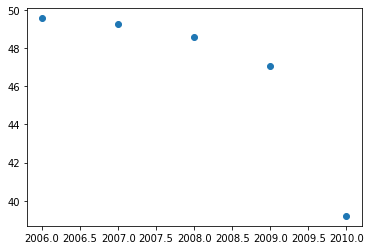

Standard Deviation (2010): (Gr Liv Area, BsmtFin SF 1) = (466.3315218117837, 428.95756489292546)
Standard Deviation (2009): (Gr Liv Area, BsmtFin SF 1) = (464.3835039850644, 462.78069546322115)
Standard Deviation (2008): (Gr Liv Area, BsmtFin SF 1) = (510.55317372302943, 482.91661898078735)
Standard Deviation (2007): (Gr Liv Area, BsmtFin SF 1) = (552.9855806751177, 452.53267874986335)
Standard Deviation (2006): (Gr Liv Area, BsmtFin SF 1) = (506.7681132937254, 437.35102323314277)

Mode (2010): (Gr Liv Area, BsmtFin SF 1) = ([1092.0], [0.0])
Mode (2009): (Gr Liv Area, BsmtFin SF 1) = ([864.0], [0.0])
Mode (2008): (Gr Liv Area, BsmtFin SF 1) = ([864.0], [0.0])
Mode (2007): (Gr Liv Area, BsmtFin SF 1) = ([864.0, 894.0, 1040.0, 1302.0], [0.0])
Mode (2006): (Gr Liv Area, BsmtFin SF 1) = ([864.0, 1092.0], [0.0])

Mean (2010): (Gr Liv Area, BsmtFin SF 1) = (1455.0, 446.1759530791789)
Mean (2009): (Gr Liv Area, BsmtFin SF 1) = (1503.3827160493827, 457.6574074074074)
Mean (2008): (Gr Liv Area,

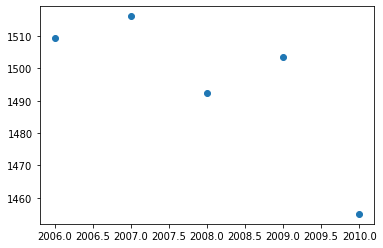

Standard Deviation (2010): (2nd Flr SF, BsmtFin SF 1) = (409.8168370558351, 428.95756489292546)
Standard Deviation (2009): (2nd Flr SF, BsmtFin SF 1) = (420.55389559725677, 462.78069546322115)
Standard Deviation (2008): (2nd Flr SF, BsmtFin SF 1) = (421.9168103265708, 482.91661898078735)
Standard Deviation (2007): (2nd Flr SF, BsmtFin SF 1) = (439.65614324604826, 452.53267874986335)
Standard Deviation (2006): (2nd Flr SF, BsmtFin SF 1) = (440.3449656861405, 437.35102323314277)

Mode (2010): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2009): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2008): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2007): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2006): (2nd Flr SF, BsmtFin SF 1) = ([0.0], [0.0])

Mean (2010): (2nd Flr SF, BsmtFin SF 1) = (320.0351906158358, 446.1759530791789)
Mean (2009): (2nd Flr SF, BsmtFin SF 1) = (327.0987654320988, 457.6574074074074)
Mean (2008): (2nd Flr SF, BsmtFin SF 1) = (347.17202572347264, 455.35

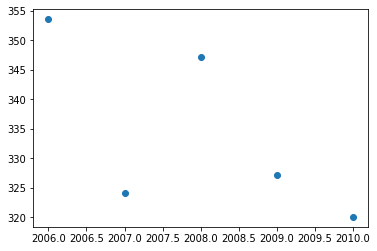

Standard Deviation (2010): (Bsmt Unf SF, BsmtFin SF 1) = (424.4499837245868, 428.95756489292546)
Standard Deviation (2009): (Bsmt Unf SF, BsmtFin SF 1) = (446.85910156373905, 462.78069546322115)
Standard Deviation (2008): (Bsmt Unf SF, BsmtFin SF 1) = (402.37403806547724, 482.91661898078735)
Standard Deviation (2007): (Bsmt Unf SF, BsmtFin SF 1) = (466.43181892897843, 452.53267874986335)
Standard Deviation (2006): (Bsmt Unf SF, BsmtFin SF 1) = (442.15733217939515, 437.35102323314277)

Mode (2010): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2009): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2008): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2007): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])
Mode (2006): (Bsmt Unf SF, BsmtFin SF 1) = ([0.0], [0.0])

Mean (2010): (Bsmt Unf SF, BsmtFin SF 1) = (537.5953079178886, 446.1759530791789)
Mean (2009): (Bsmt Unf SF, BsmtFin SF 1) = (546.1898148148148, 457.6574074074074)
Mean (2008): (Bsmt Unf SF, BsmtFin SF 1) = (532.3923981

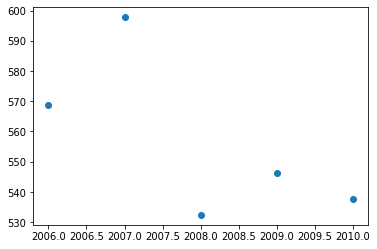

In [ ]:
for t in ['BsmtFin SF 1']:
  for n in ['Open Porch SF', 'Gr Liv Area', '2nd Flr SF', 'Bsmt Unf SF']:
    for y in temporary['Yr Sold'].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      #Find the standard deviation for this column for this year.
      std1, std2 = temp[n].std(), temp[t].std()
      print("Standard Deviation ({yr}): ({ni}, {ti}) = ({s1}, {s2})".format(yr=y, ni=n, ti=t, s1=std1, s2=std2))
    print("")

    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    temp1, temp2 = [], []
    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      temp1.append(mean1)
      temp2.append(mean2)
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

    plt.scatter([2010 - i for i in range(5)], temp1, label=n)
    plt.show()
    #plt.scatter([2010 - i for i in range(5)], temp2)

  #sns.displot(temporary, x=t, y=n, col='Yr Sold', kind="kde")
  print("")

Looking at the modes of the individual relationships, it can be seen that the only variable that is multi-modal is the Gr Liv Area. This would suggest that  there is some Nominal or Ordinal variable that is causing this multi-model distribution. However, this will be explored further in the cluster analysis below.

It can be seen that despite the spike in the mean in 2010 that there is a downwards trend for every variable combination between n and t (variables in the code). This will most likely be due to the number of houses being sold during 2008 would of dropped due to the housing crisis.

Standard Deviation (2010): (Wood Deck SF, Bsmt Unf SF) = (135.2120180395289, 424.4499837245868)
Standard Deviation (2009): (Wood Deck SF, Bsmt Unf SF) = (119.48654581329602, 446.85910156373905)
Standard Deviation (2008): (Wood Deck SF, Bsmt Unf SF) = (118.25785416785685, 402.37403806547724)
Standard Deviation (2007): (Wood Deck SF, Bsmt Unf SF) = (126.23155033631902, 466.43181892897843)
Standard Deviation (2006): (Wood Deck SF, Bsmt Unf SF) = (135.98693768341437, 442.15733217939515)

Mode (2010): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2009): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2008): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2007): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2006): (Wood Deck SF, Bsmt Unf SF) = ([0.0], [0.0])

Mean (2010): (Wood Deck SF, Bsmt Unf SF) = (99.34017595307918, 537.5953079178886)
Mean (2009): (Wood Deck SF, Bsmt Unf SF) = (94.68672839506173, 546.1898148148148)
Mean (2008): (Wood Deck SF, Bsmt Unf SF) = (87.245980707

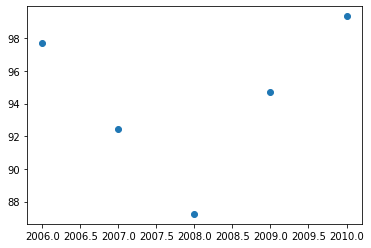

Standard Deviation (2010): (2nd Flr SF, Bsmt Unf SF) = (409.8168370558351, 424.4499837245868)
Standard Deviation (2009): (2nd Flr SF, Bsmt Unf SF) = (420.55389559725677, 446.85910156373905)
Standard Deviation (2008): (2nd Flr SF, Bsmt Unf SF) = (421.9168103265708, 402.37403806547724)
Standard Deviation (2007): (2nd Flr SF, Bsmt Unf SF) = (439.65614324604826, 466.43181892897843)
Standard Deviation (2006): (2nd Flr SF, Bsmt Unf SF) = (440.3449656861405, 442.15733217939515)

Mode (2010): (2nd Flr SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2009): (2nd Flr SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2008): (2nd Flr SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2007): (2nd Flr SF, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2006): (2nd Flr SF, Bsmt Unf SF) = ([0.0], [0.0])

Mean (2010): (2nd Flr SF, Bsmt Unf SF) = (320.0351906158358, 537.5953079178886)
Mean (2009): (2nd Flr SF, Bsmt Unf SF) = (327.0987654320988, 546.1898148148148)
Mean (2008): (2nd Flr SF, Bsmt Unf SF) = (347.17202572347264, 532.3923981870659)
M

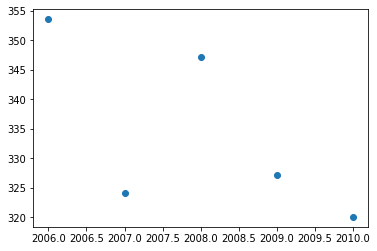

Standard Deviation (2010): (BsmtFin SF 1, Bsmt Unf SF) = (428.95756489292546, 424.4499837245868)
Standard Deviation (2009): (BsmtFin SF 1, Bsmt Unf SF) = (462.78069546322115, 446.85910156373905)
Standard Deviation (2008): (BsmtFin SF 1, Bsmt Unf SF) = (482.91661898078735, 402.37403806547724)
Standard Deviation (2007): (BsmtFin SF 1, Bsmt Unf SF) = (452.53267874986335, 466.43181892897843)
Standard Deviation (2006): (BsmtFin SF 1, Bsmt Unf SF) = (437.35102323314277, 442.15733217939515)

Mode (2010): (BsmtFin SF 1, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2009): (BsmtFin SF 1, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2008): (BsmtFin SF 1, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2007): (BsmtFin SF 1, Bsmt Unf SF) = ([0.0], [0.0])
Mode (2006): (BsmtFin SF 1, Bsmt Unf SF) = ([0.0], [0.0])

Mean (2010): (BsmtFin SF 1, Bsmt Unf SF) = (446.1759530791789, 537.5953079178886)
Mean (2009): (BsmtFin SF 1, Bsmt Unf SF) = (457.6574074074074, 546.1898148148148)
Mean (2008): (BsmtFin SF 1, Bsmt Unf SF) = (455.3576824

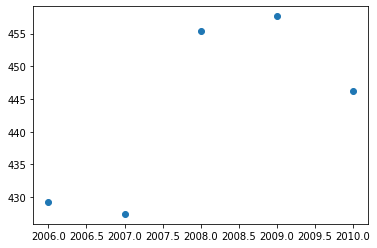

In [ ]:
for t in ['Bsmt Unf SF']:
  for n in ['Wood Deck SF', '2nd Flr SF', 'BsmtFin SF 1']:
    for y in temporary['Yr Sold'].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      #Find the standard deviation for this column for this year.
      std1, std2 = temp[n].std(), temp[t].std()
      print("Standard Deviation ({yr}): ({ni}, {ti}) = ({s1}, {s2})".format(yr=y, ni=n, ti=t, s1=std1, s2=std2))
    print("")

    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    temp1, temp2 = [], []
    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      temp1.append(mean1)
      temp2.append(mean2)
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")
    plt.scatter([2010 - i for i in range(5)], temp1)
    plt.show()

  print("")

Looking at the modes for each of these relationships, it can be seen that it is unimodel. This would mean that there is no incentive to explore this any further as there isn't any additional variables that could explain these relationships.

It can be seen that there is no obvious trend in the means for each variable. However, there is an exception to this rule is the 2nd Flr SF and the Bsmt Unf SF. This relationship is negative as the years increase until the mean of the square feet of the 2nd floor increases in 2010. This is most likely suggesting that the around the housing crisis in 2008 that most people will choose smaller houses.

Standard Deviation (2010): (SalePrice, Total Bsmt SF) = (74631.4313083648, 406.1186636310336)
Standard Deviation (2009): (SalePrice, Total Bsmt SF) = (80856.80430109256, 463.8545486090939)
Standard Deviation (2008): (SalePrice, Total Bsmt SF) = (75592.73653419659, 450.87840767452315)
Standard Deviation (2007): (SalePrice, Total Bsmt SF) = (82542.77462863794, 456.1269160431717)
Standard Deviation (2006): (SalePrice, Total Bsmt SF) = (82619.69785337095, 404.1189175198755)

Mode (2010): (SalePrice, Total Bsmt SF) = ([128000.0, 155000.0, 190000.0], [864.0])
Mode (2009): (SalePrice, Total Bsmt SF) = ([135000.0], [0.0])
Mode (2008): (SalePrice, Total Bsmt SF) = ([140000.0], [0.0, 864.0])
Mode (2007): (SalePrice, Total Bsmt SF) = ([130000.0], [0.0])
Mode (2006): (SalePrice, Total Bsmt SF) = ([137000.0, 140000.0], [0.0])

Mean (2010): (SalePrice, Total Bsmt SF) = (172597.5982404692, 1040.6304985337244)
Mean (2009): (SalePrice, Total Bsmt SF) = (181404.56790123458, 1051.2345679012346)
Mean (200

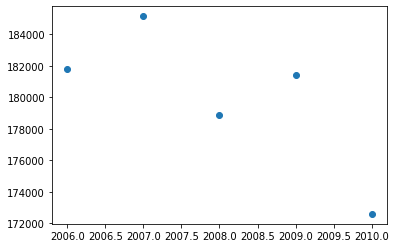

Standard Deviation (2010): (1st Flr SF, Total Bsmt SF) = (370.5678086774598, 406.1186636310336)
Standard Deviation (2009): (1st Flr SF, Total Bsmt SF) = (387.51044833099377, 463.8545486090939)
Standard Deviation (2008): (1st Flr SF, Total Bsmt SF) = (402.1094683609374, 450.87840767452315)
Standard Deviation (2007): (1st Flr SF, Total Bsmt SF) = (423.73076548419874, 456.1269160431717)
Standard Deviation (2006): (1st Flr SF, Total Bsmt SF) = (358.04137622232923, 404.1189175198755)

Mode (2010): (1st Flr SF, Total Bsmt SF) = ([600.0, 864.0], [864.0])
Mode (2009): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0])
Mode (2008): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0, 864.0])
Mode (2007): (1st Flr SF, Total Bsmt SF) = ([1040.0], [0.0])
Mode (2006): (1st Flr SF, Total Bsmt SF) = ([864.0], [0.0])

Mean (2010): (1st Flr SF, Total Bsmt SF) = (1132.7595307917888, 1040.6304985337244)
Mean (2009): (1st Flr SF, Total Bsmt SF) = (1169.125, 1051.2345679012346)
Mean (2008): (1st Flr SF, Total Bsmt SF

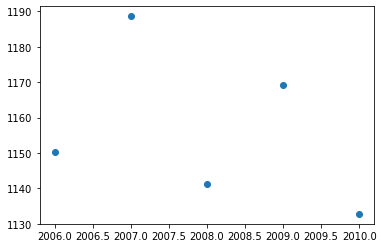

Standard Deviation (2010): (2nd Flr SF, Total Bsmt SF) = (409.8168370558351, 406.1186636310336)
Standard Deviation (2009): (2nd Flr SF, Total Bsmt SF) = (420.55389559725677, 463.8545486090939)
Standard Deviation (2008): (2nd Flr SF, Total Bsmt SF) = (421.9168103265708, 450.87840767452315)
Standard Deviation (2007): (2nd Flr SF, Total Bsmt SF) = (439.65614324604826, 456.1269160431717)
Standard Deviation (2006): (2nd Flr SF, Total Bsmt SF) = (440.3449656861405, 404.1189175198755)

Mode (2010): (2nd Flr SF, Total Bsmt SF) = ([0.0], [864.0])
Mode (2009): (2nd Flr SF, Total Bsmt SF) = ([0.0], [0.0])
Mode (2008): (2nd Flr SF, Total Bsmt SF) = ([0.0], [0.0, 864.0])
Mode (2007): (2nd Flr SF, Total Bsmt SF) = ([0.0], [0.0])
Mode (2006): (2nd Flr SF, Total Bsmt SF) = ([0.0], [0.0])

Mean (2010): (2nd Flr SF, Total Bsmt SF) = (320.0351906158358, 1040.6304985337244)
Mean (2009): (2nd Flr SF, Total Bsmt SF) = (327.0987654320988, 1051.2345679012346)
Mean (2008): (2nd Flr SF, Total Bsmt SF) = (347.17

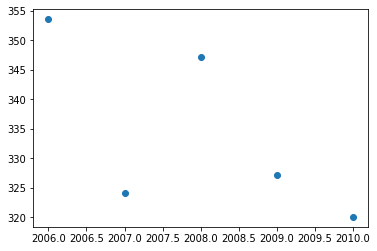

In [ ]:
for t in ['Total Bsmt SF']:
  for n in ['SalePrice', '1st Flr SF', '2nd Flr SF']:
    for y in temporary['Yr Sold'].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      #Find the standard deviation for this column for this year.
      std1, std2 = temp[n].std(), temp[t].std()
      print("Standard Deviation ({yr}): ({ni}, {ti}) = ({s1}, {s2})".format(yr=y, ni=n, ti=t, s1=std1, s2=std2))
    print("")

    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    temp1, temp2 = [], []
    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      temp1.append(mean1)
      temp2.append(mean2)
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")

    plt.scatter([2010 - i for i in range(5)], temp1)
    plt.show()

  print("")

Looking at the trend for each mean, it can be seen that the only variable with a visible trend over the years in the dataset is the 2nd Floor SF variable which has been explained in the above text block.

Looking at 1st Flr SF variable, it can be seen that during 2010 and 2007 the variable is multi-modal. To draw any conclusions, there will need to be some additional variables to identify why it is multi-modal. As the variables (from the bivariate analysis) in the above code block has been combined with this variable, this will be explored further in the cluster analysis section below.

Looking at the SalePrice variable, it can be seen that during 2010, 2009 and 2006 that it is also multi-modal. For the same reason as the 1st Flr SF variable, this variable will be explored further in the cluster analysis section below.

Standard Deviation (2010): (SalePrice, Gr Liv Area) = (74631.4313083648, 466.3315218117837)
Standard Deviation (2009): (SalePrice, Gr Liv Area) = (80856.80430109256, 464.3835039850644)
Standard Deviation (2008): (SalePrice, Gr Liv Area) = (75592.73653419659, 510.55317372302943)
Standard Deviation (2007): (SalePrice, Gr Liv Area) = (82542.77462863794, 552.9855806751177)
Standard Deviation (2006): (SalePrice, Gr Liv Area) = (82619.69785337095, 506.7681132937254)

Mode (2010): (SalePrice, Gr Liv Area) = ([128000.0, 155000.0, 190000.0], [1092.0])
Mode (2009): (SalePrice, Gr Liv Area) = ([135000.0], [864.0])
Mode (2008): (SalePrice, Gr Liv Area) = ([140000.0], [864.0])
Mode (2007): (SalePrice, Gr Liv Area) = ([130000.0], [864.0, 894.0, 1040.0, 1302.0])
Mode (2006): (SalePrice, Gr Liv Area) = ([137000.0, 140000.0], [864.0, 1092.0])

Mean (2010): (SalePrice, Gr Liv Area) = (172597.5982404692, 1455.0)
Mean (2009): (SalePrice, Gr Liv Area) = (181404.56790123458, 1503.3827160493827)
Mean (2008):

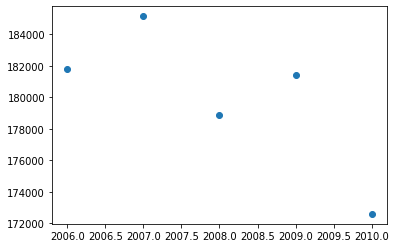

Standard Deviation (2010): (1st Flr SF, Gr Liv Area) = (370.5678086774598, 466.3315218117837)
Standard Deviation (2009): (1st Flr SF, Gr Liv Area) = (387.51044833099377, 464.3835039850644)
Standard Deviation (2008): (1st Flr SF, Gr Liv Area) = (402.1094683609374, 510.55317372302943)
Standard Deviation (2007): (1st Flr SF, Gr Liv Area) = (423.73076548419874, 552.9855806751177)
Standard Deviation (2006): (1st Flr SF, Gr Liv Area) = (358.04137622232923, 506.7681132937254)

Mode (2010): (1st Flr SF, Gr Liv Area) = ([600.0, 864.0], [1092.0])
Mode (2009): (1st Flr SF, Gr Liv Area) = ([864.0], [864.0])
Mode (2008): (1st Flr SF, Gr Liv Area) = ([864.0], [864.0])
Mode (2007): (1st Flr SF, Gr Liv Area) = ([1040.0], [864.0, 894.0, 1040.0, 1302.0])
Mode (2006): (1st Flr SF, Gr Liv Area) = ([864.0], [864.0, 1092.0])

Mean (2010): (1st Flr SF, Gr Liv Area) = (1132.7595307917888, 1455.0)
Mean (2009): (1st Flr SF, Gr Liv Area) = (1169.125, 1503.3827160493827)
Mean (2008): (1st Flr SF, Gr Liv Area) = (

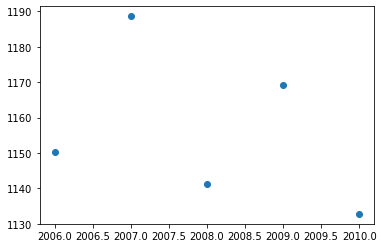

Standard Deviation (2010): (BsmtFin SF 1, Gr Liv Area) = (428.95756489292546, 466.3315218117837)
Standard Deviation (2009): (BsmtFin SF 1, Gr Liv Area) = (462.78069546322115, 464.3835039850644)
Standard Deviation (2008): (BsmtFin SF 1, Gr Liv Area) = (482.91661898078735, 510.55317372302943)
Standard Deviation (2007): (BsmtFin SF 1, Gr Liv Area) = (452.53267874986335, 552.9855806751177)
Standard Deviation (2006): (BsmtFin SF 1, Gr Liv Area) = (437.35102323314277, 506.7681132937254)

Mode (2010): (BsmtFin SF 1, Gr Liv Area) = ([0.0], [1092.0])
Mode (2009): (BsmtFin SF 1, Gr Liv Area) = ([0.0], [864.0])
Mode (2008): (BsmtFin SF 1, Gr Liv Area) = ([0.0], [864.0])
Mode (2007): (BsmtFin SF 1, Gr Liv Area) = ([0.0], [864.0, 894.0, 1040.0, 1302.0])
Mode (2006): (BsmtFin SF 1, Gr Liv Area) = ([0.0], [864.0, 1092.0])

Mean (2010): (BsmtFin SF 1, Gr Liv Area) = (446.1759530791789, 1455.0)
Mean (2009): (BsmtFin SF 1, Gr Liv Area) = (457.6574074074074, 1503.3827160493827)
Mean (2008): (BsmtFin SF 1

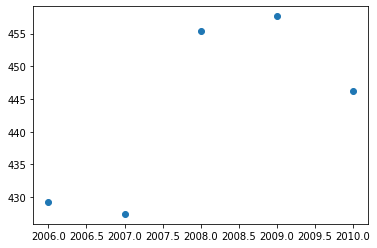

In [ ]:
for t in ['Gr Liv Area']:
  for n in ['SalePrice', '1st Flr SF', 'BsmtFin SF 1']:
    for y in temporary['Yr Sold'].unique():
      #Find the subset of the data based on the year.
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      #Find the standard deviation for this column for this year.
      std1, std2 = temp[n].std(), temp[t].std()
      print("Standard Deviation ({yr}): ({ni}, {ti}) = ({s1}, {s2})".format(yr=y, ni=n, ti=t, s1=std1, s2=std2))
    print("")

    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mode1, mode2 = [a for a in temp[n].mode()], [a for a in temp[t].mode()]
      print("Mode ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mode1, m2=mode2))
    print("")

    temp1, temp2 = [], []
    for y in temporary['Yr Sold'].unique():
      temp = temporary[temporary['Yr Sold'] == str(y)]
      temp = temp[['Yr Sold', n, t]]

      mean1, mean2 = temp[n].mean(), temp[t].mean()
      temp1.append(mean1)
      temp2.append(mean2)
      print("Mean ({yr}): ({ni}, {ti}) = ({m1}, {m2})".format(yr=y, ni=n, ti=t, m1=mean1, m2=mean2))
    print("")
    plt.scatter([2010 - i for i in range(5)], temp1)
    plt.show()

  print("")

Looking at the modes (frequency of the values) for each variable that is in the above code block, it can be seen that the Gr Liv Area, SalePrice and 1st Flr SF variables are all multi-modal. These variables have been discusses in this section before and will still be analysed further in the cluster analysis section below.

Looking at the means, it can be seen that there is no obvious trend when the variables are split by the year the houses where sold. This most likely means there is another variable that would be more appropriate for this.

##Cluster Analysis

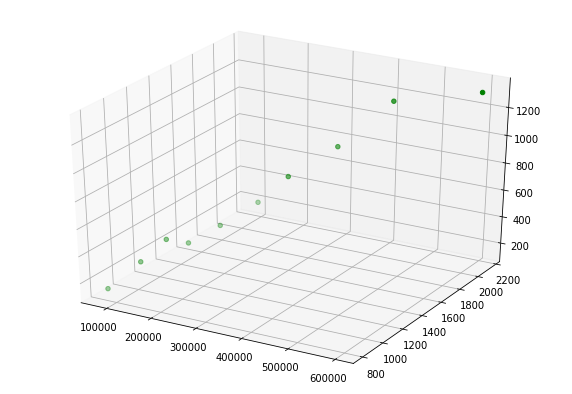

In [ ]:
#from sklearn.clusters import KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

wcss, centers = [], []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(temporary[['SalePrice', '1st Flr SF', 'BsmtFin SF 1']])
    wcss.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)

n = len(centers)-1
x, y, z = [t[0] for t in centers[n]], [t[1] for t in centers[n]], [t[2] for t in centers[n]]  
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "green")
plt.show()

Looking at the visualization, it can be seen that when the x-axis (SalePrice) and the y-axis (1st Flr SF) that the z-axis (BsmtFin SF 1) increases as well. This would suggest that as the as the price increases for the household and the more spacious the 1st floor is, the more area (that is finished) the basement will be.

However,  the centers of these clusters are more sporadic which would suggest that this is less likely than when the price of the house is lower.

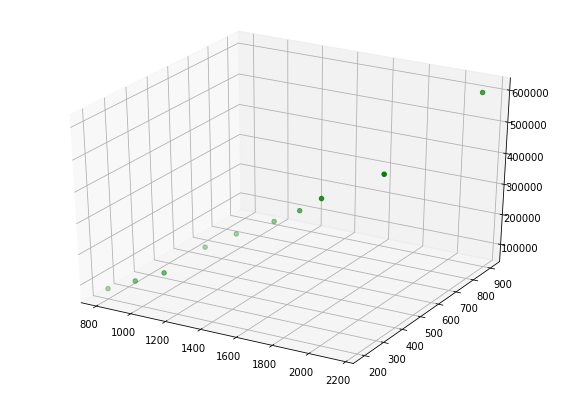

In [ ]:
wcss, centers = [], []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(temporary[['1st Flr SF', '2nd Flr SF', 'SalePrice']])
    wcss.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)

n = len(centers)-1
x, y, z = [t[0] for t in centers[n]], [t[1] for t in centers[n]], [t[2] for t in centers[n]]  
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "green")
plt.show()

Looking at the variables, there appears to be 2 distinct groups of clusters that follow a linear trend between the variables. These groups appear to be split on the y-axis (2nd Floor SF) which would suggest that there is some additional variable relating to the 2nd floor that needs to be explored to explain this distinction.

It can also be seen that as the Sale Price of the household (z-axis), that the area (square feet) of the 1st floor (x-axis) and the 2nd floor (y-axis) increases as well. This had been identified before in the bivariate and multivariate analysis sections and suggests that the amount of space each floor has has a positive correlation to the price of the household.

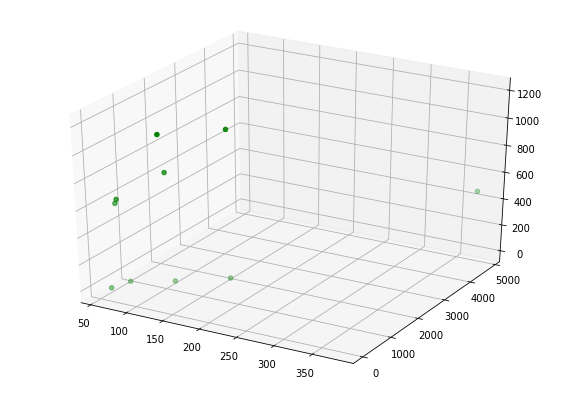

In [ ]:
wcss, centers = [], []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(temporary[['Wood Deck SF', 'BsmtFin SF 1', '2nd Flr SF']])
    wcss.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)

n = len(centers)-1
x, y, z = [t[0] for t in centers[n]], [t[1] for t in centers[n]], [t[2] for t in centers[n]]  
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "green")
plt.show()

Looking at the visualization, it can be seen that the majority of the clusters are below the value of 100 for the x-axis and is between 0 and 600 or 800 and 1200 for the y-axis. This would suggest that there is a lot of distinct groups related to the size of  the house's Wooden Deck and the area of the basement that is finished. To draw a firmer conclusion, this would need to be explored further by splitting by the appropriate Nominal and Ordinal variables.

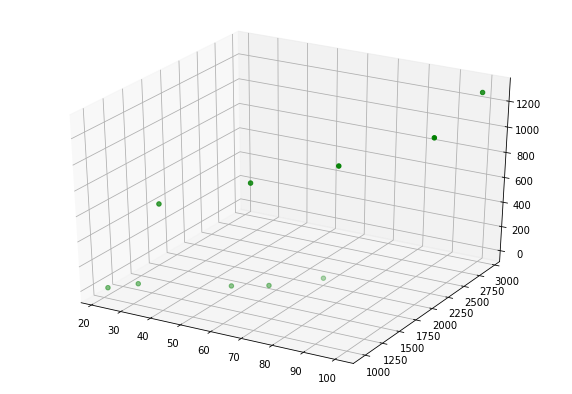

In [ ]:
wcss, centers = [], []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(temporary[['Open Porch SF', 'Gr Liv Area', '2nd Flr SF', 'Bsmt Unf SF']])
    wcss.append(kmeans.inertia_)
    centers.append(kmeans.cluster_centers_)

n = len(centers)-1
x, y, z = [t[0] for t in centers[n]], [t[1] for t in centers[n]], [t[2] for t in centers[n]]  
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x, y, z, color = "green")
plt.show()

As it can be seen in the visualization, the clusters are "more sparse" the larger the values are. This would suggest that the majority of the data entries are smaller than about 50% of the maximum value.

There is a fair amount of variance among the cluster center's along the z-axis. This would suggest that this would be the positions of the peaks (modes) of the columns.